# Segment Customers based on RFM Variables

In [1]:
# อิติปาระมิตา ติงสา อิติสัพพัญญะ มาคะตา
# อิติโพธิ มุนุปปัตโต อิติปิโส จะตะมะโน
# นะเมตตา โมกรุณา พุทธปราณี ธายินดี
# ยะเอ็นดู ยะหันตวา ธามัวเมา พุทพาเอา นะโมพุทธายะ

%matplotlib widget

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import plotly.offline as pyoff
import plotly.graph_objs as go

import datetime as dt
import feature_engine

from feature_engine.outliers import Winsorizer
from mpl_toolkits.mplot3d import Axes3D
import plotly
import plotly.graph_objs as go

from sklearn.model_selection import train_test_split
from keras.utils import np_utils 
import numpy as np

from pycaret.regression import * 
# from pycaret.classification import *


import warnings
warnings.filterwarnings("ignore")

In [48]:
# Load Dataset

df = pd.read_csv('2019.csv')
df = df[['รหัสลูกค้า','ช่องทาง','CalendarDay','Week','Site_Key','Site_MediumText','Product_Champion','Article','Sales_Excld','QTY','Unit_Price']]


df2 = pd.read_csv('2020.csv')
df2 = df2[['รหัสลูกค้า','ช่องทาง','CalendarDay','Week','Site_Key','Site_MediumText','Product_Champion','Article','Sales_Excld','QTY','Unit_Price']]


df3 = pd.read_csv('2021.csv')
df3 = df3[['รหัสลูกค้า','ช่องทาง','CalendarDay','Week','Site_Key','Site_MediumText','Product_Champion','Article','Sales_Excld','QTY','Unit_Price']]


df = df.append(df2, ignore_index = True)
df = df.append(df3, ignore_index = True)

df = df.rename(columns = {'รหัสลูกค้า': 'Customer_ID', 'ช่องทาง': 'Channel'}, inplace = False)

df[["Month", "Day", "Year"]] = df["CalendarDay"].str.split("/", expand = True)

df['CalendarDay'] = pd.to_datetime(df['CalendarDay'])


df = df[df['Product_Champion'].isin(['Egg', 'Other ', 'Poultry', 'Process Food', 'Process Meat', 'Swine']) & df['Site_Key'].isin(['S035','S154','S031'])]
# df = df[['รหัสลูกค้า','ช่องทาง','CalendarDay','Week','Site_Key','Site_MediumText','Product_Champion','Article_Key','Article','Sales_Excld']]
# 'Egg', 'Other', 'Poultry', 'Process Food', 'Process Meat', 'Swine'
# 'เบทาโกรช็อป สาขามุกดาหาร' , 'เบทาโกรช็อป สาขาธาตุพนม' ,'เบทาโกรช็อป สาขาหนองคาย'

df
# print(df)

Customer_ID       Channel CalendarDay        Week Site_Key  \
0                23     WHOLESALE  2019-04-01   4_W1_2019     S031   
1               798  FOOD SERVICE  2019-04-01   4_W1_2019     S035   
2              1116  FOOD SERVICE  2019-04-01   4_W1_2019     S154   
3               263     WHOLESALE  2019-04-01   4_W1_2019     S154   
4                19    INDUSTRIAL  2019-04-01   4_W1_2019     S031   
...             ...           ...         ...         ...      ...   
234675          341     WHOLESALE  2021-12-31  12_W5_2021     S035   
234676          695     WHOLESALE  2021-12-31  12_W5_2021     S035   
234677          308     WHOLESALE  2021-12-31  12_W5_2021     S154   
234678          431  FOOD SERVICE  2021-12-31  12_W5_2021     S154   
234679          695     WHOLESALE  2021-12-31  12_W5_2021     S035   

                 Site_MediumText Product_Champion  \
0        เบทาโกรช็อป สาขาหนองคาย          Poultry   
1       เบทาโกรช็อป สาขามุกดาหาร          Poultry   
2        เบทาโกรช็อป สาขาธาตุพนม     Process Meat   
3        เบทาโกรช็อป สาขาธาตุพนม          Poultry   
4        เบทาโกรช็อป สาขาหนองคาย          Poultry   
...                          ...              ...   
234675  เบทาโกรช็อป สาขามุกดาหาร            Swine   
234676  เบทาโกรช็อป สาขามุกดาหาร     Process Food   
234677   เบทาโกรช็อป สาขาธาตุพนม     Process Food   
234678   เบทาโกรช็อป สาขาธาตุพนม           Other    
234679  เบทาโกรช็อป สาขามุกดาหาร           Other    

                                         Article  Sales_Excld     QTY  \
0                       FR CK เลือดไก่ 5 ก้อน HB        25.00   2.000   
1                  FR CK เลือดไก่ก้อน 10 ก้อน HB        40.00   1.000   
2           SS CK BTG คอกเทลหนังบางกรอบ ACO 500ก        56.07   1.000   
3                        FR CK ขาซีไก่ A BTG 1กก        80.00   1.000   
4             FR CK ไก่ บ้านอิสานล้วง แพ็ค 1 ตัว        81.60   0.960   
...                                          ...          ...     ...   
234675                   FR PK BTG กะโหลกหมู-2/K        36.72  12.240   
234676  น้ำซุปหมูสูตรเข้มข้น/140g(50pack/carton)        36.45   0.140   
234677          ST CK SBB&BL&SKIN BTG นักเก็ตไก่        28.04   1.000   
234678           ซอสมะเขือเทศ ตราเด็กสมบูรณ์ 1kg        24.17   0.083   
234679           BO EG BTG เต้าหู้ไข่อนามัยH120ก        22.42   0.360   

         Unit_Price Month Day  Year  
0               5.0     4   1  2019  
1               4.0     4   1  2019  
2             56.07     4   1  2019  
3              80.0     4   1  2019  
4              85.0     4   1  2019  
...             ...   ...  ..   ...  
234675            3    12  31  2021  
234676        36.45    12  31  2021  
234677        28.04    12  31  2021  
234678        24.17    12  31  2021  
234679  7.473333333    12  31  2021  

[234680 rows x 14 columns]

In [49]:
df.shape

(234680, 14)

## Data Preparation

In [50]:
def summary(df, pred=None):
  obs = df.shape[0]
  types = df.dtypes
  counts = df.apply(lambda x: x.count())
  min = df.min()
  uniques = df.apply(lambda x: x.unique().shape[0])
  nulls = df.apply(lambda x: x.isnull().sum())
  print('Data shape:', df.shape)

  if pred is None:
        cols = ['types', 'counts', 'uniques', 'nulls', 'min']
        str = pd.concat([types, counts, uniques, nulls, min], axis = 1, sort=True)

  str.columns = cols
  dtypes = str.types.value_counts()
  print('___________________________\nData types:')
  print(str.types.value_counts())
  print('___________________________')
  return str

details = summary(df)
display(details.sort_values(by='nulls', ascending=False))

Data shape: (234680, 14)
___________________________
Data types:
object            10
float64            2
datetime64[ns]     1
int64              1
Name: types, dtype: int64
___________________________


types  counts  uniques  nulls  \
QTY                      float64  234631     7779     49   
Article                   object  234680      987      0   
CalendarDay       datetime64[ns]  234680      865      0   
Channel                   object  234680        3      0   
Customer_ID                int64  234680     1754      0   
Day                       object  234680       31      0   
Month                     object  234680       12      0   
Product_Champion          object  234680        6      0   
Sales_Excld              float64  234680    20918      0   
Site_Key                  object  234680        3      0   
Site_MediumText           object  234680        3      0   
Unit_Price                object  234680     4526      0   
Week                      object  234680      143      0   
Year                      object  234680        3      0   

                                                   min  
QTY                                                0.0  
Article           BA CK BTG ลูกชิ้นแฟนซีรักบี้ BH 500ก  
CalendarDay                        2019-04-01 00:00:00  
Channel                                   FOOD SERVICE  
Customer_ID                                          1  
Day                                                  1  
Month                                                1  
Product_Champion                                   Egg  
Sales_Excld                                      -0.01  
Site_Key                                          S031  
Site_MediumText                เบทาโกรช็อป สาขาธาตุพนม  
Unit_Price                                         NaN  
Week                                        10_W1_2019  
Year                                              2019

In [51]:
df.describe()

Customer_ID    Sales_Excld            QTY
count  234680.000000  234680.000000  234631.000000
mean      364.763486    2091.911358     221.823480
std       384.380805    8081.662564     870.484054
min         1.000000      -0.010000       0.000000
25%       121.000000     500.000000       9.080000
50%       228.000000     934.580000      15.750000
75%       422.000000    1800.000000      50.000000
max      1778.000000  811680.000000   94500.000000

In [52]:
df.isnull().mean()*100

Customer_ID         0.000000
Channel             0.000000
CalendarDay         0.000000
Week                0.000000
Site_Key            0.000000
Site_MediumText     0.000000
Product_Champion    0.000000
Article             0.000000
Sales_Excld         0.000000
QTY                 0.020879
Unit_Price          0.000000
Month               0.000000
Day                 0.000000
Year                0.000000
dtype: float64

In [53]:
df.loc[(df.Sales_Excld<1)]


Customer_ID       Channel CalendarDay        Week Site_Key  \
8359             29  FOOD SERVICE  2019-05-16   5_W3_2019     S031   
23796          1185  FOOD SERVICE  2019-07-27   7_W4_2019     S154   
25522           201  FOOD SERVICE  2019-08-05   8_W2_2019     S154   
45438           749  FOOD SERVICE  2019-11-06  11_W1_2019     S031   
47308           724  FOOD SERVICE  2019-11-14  11_W2_2019     S031   
...             ...           ...         ...         ...      ...   
234487          633  FOOD SERVICE  2021-12-30  12_W5_2021     S031   
234488          461     WHOLESALE  2021-12-30  12_W5_2021     S031   
234489          461     WHOLESALE  2021-12-30  12_W5_2021     S031   
234490          453     WHOLESALE  2021-12-30  12_W5_2021     S031   
234491          454     WHOLESALE  2021-12-30  12_W5_2021     S154   

                Site_MediumText Product_Champion  \
8359    เบทาโกรช็อป สาขาหนองคาย              Egg   
23796   เบทาโกรช็อป สาขาธาตุพนม     Process Meat   
25522   เบทาโกรช็อป สาขาธาตุพนม     Process Meat   
45438   เบทาโกรช็อป สาขาหนองคาย           Other    
47308   เบทาโกรช็อป สาขาหนองคาย     Process Food   
...                         ...              ...   
234487  เบทาโกรช็อป สาขาหนองคาย     Process Meat   
234488  เบทาโกรช็อป สาขาหนองคาย     Process Food   
234489  เบทาโกรช็อป สาขาหนองคาย     Process Food   
234490  เบทาโกรช็อป สาขาหนองคาย     Process Food   
234491  เบทาโกรช็อป สาขาธาตุพนม     Process Food   

                                         Article  Sales_Excld     QTY  \
8359                  Egg No.3 (Betagro) Pack 30          0.0  30.000   
23796    SS P&C BTG เม็กซิกันชิโปเล่ชีส ACO 500ก          0.0   0.500   
25522   SS P&C BTGอิตาเลียนออริกาโน่ชีส ACO 500ก          0.0   0.500   
45438            ซอสมะเขือเทศ ตราเด็กสมบูรณ์ 1kg          0.0   0.083   
47308     FY CK BL-K ชุบแป้งทอด JAPANESE KARAAGE          0.0   1.000   
...                                          ...          ...     ...   
234487           BA P&C BTG ลูกชิ้นปรุงรส B 500ก          0.0   0.500   
234488            RO CK BBK BTG BBQ SPICY 1KG FZ          0.0   1.000   
234489           DC PK BTG กะเพราหมูโบราณ 1KG FZ          0.0   1.000   
234490             FY CK BLK THE KARAAGE(JKHT-C)          0.0   1.000   
234491          ST CK SBB&BL&SKIN BTG นักเก็ตไก่          0.0   1.000   

       Unit_Price Month Day  Year  
8359          0.0     5  16  2019  
23796         0.0     7  27  2019  
25522         0.0     8   5  2019  
45438         0.0    11   6  2019  
47308         0.0    11  14  2019  
...           ...   ...  ..   ...  
234487          0    12  30  2021  
234488          0    12  30  2021  
234489          0    12  30  2021  
234490          0    12  30  2021  
234491          0    12  30  2021  

[505 rows x 14 columns]

In [57]:
df = df[df.Sales_Excld > 2]
df = df[df.QTY > 0]
df = df[df.Unit_Price.astype(float) > 0]
df['Check_Sale'] = df['QTY'].astype(float) * df['Unit_Price'].astype(float)
df = df[df.Sales_Excld == df.Check_Sale]
df.drop(columns=['Check_Sale'],inplace=True)
df = df.reset_index(drop=True)
df

Customer_ID       Channel CalendarDay        Week Site_Key  \
0              1116  FOOD SERVICE  2019-04-01   4_W1_2019     S154   
1               263     WHOLESALE  2019-04-01   4_W1_2019     S154   
2                19    INDUSTRIAL  2019-04-01   4_W1_2019     S031   
3              1043  FOOD SERVICE  2019-04-01   4_W1_2019     S035   
4              1071  FOOD SERVICE  2019-04-01   4_W1_2019     S031   
...             ...           ...         ...         ...      ...   
169806           21  FOOD SERVICE  2021-12-31  12_W5_2021     S031   
169807          338  FOOD SERVICE  2021-12-31  12_W5_2021     S154   
169808          214     WHOLESALE  2021-12-31  12_W5_2021     S031   
169809          341     WHOLESALE  2021-12-31  12_W5_2021     S035   
169810          308     WHOLESALE  2021-12-31  12_W5_2021     S154   

                 Site_MediumText Product_Champion  \
0        เบทาโกรช็อป สาขาธาตุพนม     Process Meat   
1        เบทาโกรช็อป สาขาธาตุพนม          Poultry   
2        เบทาโกรช็อป สาขาหนองคาย          Poultry   
3       เบทาโกรช็อป สาขามุกดาหาร            Swine   
4        เบทาโกรช็อป สาขาหนองคาย     Process Meat   
...                          ...              ...   
169806   เบทาโกรช็อป สาขาหนองคาย          Poultry   
169807   เบทาโกรช็อป สาขาธาตุพนม           Other    
169808   เบทาโกรช็อป สาขาหนองคาย     Process Food   
169809  เบทาโกรช็อป สาขามุกดาหาร            Swine   
169810   เบทาโกรช็อป สาขาธาตุพนม     Process Food   

                                        Article  Sales_Excld    QTY  \
0          SS CK BTG คอกเทลหนังบางกรอบ ACO 500ก        56.07   1.00   
1                       FR CK ขาซีไก่ A BTG 1กก        80.00   1.00   
2            FR CK ไก่ บ้านอิสานล้วง แพ็ค 1 ตัว        81.60   0.96   
3       MN PK BTG สะโพกปรุงรสกระเทียมพริกไทย FZ        89.72   0.64   
4       SS P&C BTGฮอทดอกเดอลุกซ์8(BOI-LR)ACE1กก       112.15   1.00   
...                                         ...          ...    ...   
169806            FR CK BB BTG เนื้อไก่บีบี 1กก        81.00   1.00   
169807                FR DK เครื่องในเป็ดชุดรวม        72.00   1.00   
169808      FY-RO CK SBB STRIPPERS (97530311-C)        54.51   1.00   
169809                  FR PK BTG กะโหลกหมู-2/K        36.72  12.24   
169810         ST CK SBB&BL&SKIN BTG นักเก็ตไก่        28.04   1.00   

       Unit_Price Month Day  Year  
0           56.07     4   1  2019  
1            80.0     4   1  2019  
2            85.0     4   1  2019  
3        140.1875     4   1  2019  
4          112.15     4   1  2019  
...           ...   ...  ..   ...  
169806         81    12  31  2021  
169807         72    12  31  2021  
169808      54.51    12  31  2021  
169809          3    12  31  2021  
169810      28.04    12  31  2021  

[169811 rows x 14 columns]

In [58]:
# #Removing the Null values from the data.
df = df[pd.notnull(df['Customer_ID'])]

In [59]:
df

Customer_ID       Channel CalendarDay        Week Site_Key  \
0              1116  FOOD SERVICE  2019-04-01   4_W1_2019     S154   
1               263     WHOLESALE  2019-04-01   4_W1_2019     S154   
2                19    INDUSTRIAL  2019-04-01   4_W1_2019     S031   
3              1043  FOOD SERVICE  2019-04-01   4_W1_2019     S035   
4              1071  FOOD SERVICE  2019-04-01   4_W1_2019     S031   
...             ...           ...         ...         ...      ...   
169806           21  FOOD SERVICE  2021-12-31  12_W5_2021     S031   
169807          338  FOOD SERVICE  2021-12-31  12_W5_2021     S154   
169808          214     WHOLESALE  2021-12-31  12_W5_2021     S031   
169809          341     WHOLESALE  2021-12-31  12_W5_2021     S035   
169810          308     WHOLESALE  2021-12-31  12_W5_2021     S154   

                 Site_MediumText Product_Champion  \
0        เบทาโกรช็อป สาขาธาตุพนม     Process Meat   
1        เบทาโกรช็อป สาขาธาตุพนม          Poultry   
2        เบทาโกรช็อป สาขาหนองคาย          Poultry   
3       เบทาโกรช็อป สาขามุกดาหาร            Swine   
4        เบทาโกรช็อป สาขาหนองคาย     Process Meat   
...                          ...              ...   
169806   เบทาโกรช็อป สาขาหนองคาย          Poultry   
169807   เบทาโกรช็อป สาขาธาตุพนม           Other    
169808   เบทาโกรช็อป สาขาหนองคาย     Process Food   
169809  เบทาโกรช็อป สาขามุกดาหาร            Swine   
169810   เบทาโกรช็อป สาขาธาตุพนม     Process Food   

                                        Article  Sales_Excld    QTY  \
0          SS CK BTG คอกเทลหนังบางกรอบ ACO 500ก        56.07   1.00   
1                       FR CK ขาซีไก่ A BTG 1กก        80.00   1.00   
2            FR CK ไก่ บ้านอิสานล้วง แพ็ค 1 ตัว        81.60   0.96   
3       MN PK BTG สะโพกปรุงรสกระเทียมพริกไทย FZ        89.72   0.64   
4       SS P&C BTGฮอทดอกเดอลุกซ์8(BOI-LR)ACE1กก       112.15   1.00   
...                                         ...          ...    ...   
169806            FR CK BB BTG เนื้อไก่บีบี 1กก        81.00   1.00   
169807                FR DK เครื่องในเป็ดชุดรวม        72.00   1.00   
169808      FY-RO CK SBB STRIPPERS (97530311-C)        54.51   1.00   
169809                  FR PK BTG กะโหลกหมู-2/K        36.72  12.24   
169810         ST CK SBB&BL&SKIN BTG นักเก็ตไก่        28.04   1.00   

       Unit_Price Month Day  Year  
0           56.07     4   1  2019  
1            80.0     4   1  2019  
2            85.0     4   1  2019  
3        140.1875     4   1  2019  
4          112.15     4   1  2019  
...           ...   ...  ..   ...  
169806         81    12  31  2021  
169807         72    12  31  2021  
169808      54.51    12  31  2021  
169809          3    12  31  2021  
169810      28.04    12  31  2021  

[169811 rows x 14 columns]

In [60]:
FM_Table = df.groupby('Customer_ID').agg({'Customer_ID': lambda x:len(x),'Sales_Excld'  : lambda x:x.sum()})

GB = df.copy()

GB = df.groupby(['Year','Month','Customer_ID']).agg({'Customer_ID': lambda x:len(x),'Sales_Excld': lambda x:x.sum(),'CalendarDay' : lambda x: x.max()})
GB.rename(columns = {'Customer_ID' :'Frequency','Sales_Excld':'Monetary'},inplace= True)
GB.to_excel("Group.xlsx")
GB

# G_FM_Table = GB.groupby(['Year','Month','Customer_ID']).agg({'Customer_ID': lambda x:len(x),'Sales_Excld'  : lambda x:x.sum()})
# G_FM_Table.rename(columns = {'Customer_ID' :'Frequency','Sales_Excld':'Monetary'},inplace= True)


Frequency  Monetary CalendarDay
Year Month Customer_ID                                 
2019 10    1                   28  14667.00  2019-10-31
           2                   13  29790.00  2019-10-31
           4                   11  97107.70  2019-10-31
           5                  104  93200.00  2019-10-31
           6                    2    516.00  2019-10-26
...                           ...       ...         ...
2021 9     1772                 2    290.00  2021-09-21
           1773                 3   1440.50  2021-09-29
           1776                 4    571.44  2021-09-11
           1777                 7   2653.10  2021-09-22
           1778                 1    466.20  2021-09-20

[10964 rows x 3 columns]

In [61]:
GB = GB.reset_index()
GB

Year Month  Customer_ID  Frequency  Monetary CalendarDay
0      2019    10            1         28  14667.00  2019-10-31
1      2019    10            2         13  29790.00  2019-10-31
2      2019    10            4         11  97107.70  2019-10-31
3      2019    10            5        104  93200.00  2019-10-31
4      2019    10            6          2    516.00  2019-10-26
...     ...   ...          ...        ...       ...         ...
10959  2021     9         1772          2    290.00  2021-09-21
10960  2021     9         1773          3   1440.50  2021-09-29
10961  2021     9         1776          4    571.44  2021-09-11
10962  2021     9         1777          7   2653.10  2021-09-22
10963  2021     9         1778          1    466.20  2021-09-20

[10964 rows x 6 columns]

In [62]:
df['Postdate'] = pd.to_datetime(df['CalendarDay'])

GB['Postdate'] = pd.to_datetime(GB['CalendarDay'])


In [63]:
df.isnull().mean()

GB.isnull().mean()

Year           0.0
Month          0.0
Customer_ID    0.0
Frequency      0.0
Monetary       0.0
CalendarDay    0.0
Postdate       0.0
dtype: float64

## RFM Analysis

In [64]:
NOW = dt.date(2022,2,1) 
df['Date'] = pd.DatetimeIndex(df.Postdate).date

GB['Date'] = pd.DatetimeIndex(GB.Postdate).date
GB

Year Month  Customer_ID  Frequency  Monetary CalendarDay   Postdate  \
0      2019    10            1         28  14667.00  2019-10-31 2019-10-31   
1      2019    10            2         13  29790.00  2019-10-31 2019-10-31   
2      2019    10            4         11  97107.70  2019-10-31 2019-10-31   
3      2019    10            5        104  93200.00  2019-10-31 2019-10-31   
4      2019    10            6          2    516.00  2019-10-26 2019-10-26   
...     ...   ...          ...        ...       ...         ...        ...   
10959  2021     9         1772          2    290.00  2021-09-21 2021-09-21   
10960  2021     9         1773          3   1440.50  2021-09-29 2021-09-29   
10961  2021     9         1776          4    571.44  2021-09-11 2021-09-11   
10962  2021     9         1777          7   2653.10  2021-09-22 2021-09-22   
10963  2021     9         1778          1    466.20  2021-09-20 2021-09-20   

             Date  
0      2019-10-31  
1      2019-10-31  
2      2019-10-31  
3      2019-10-31  
4      2019-10-26  
...           ...  
10959  2021-09-21  
10960  2021-09-29  
10961  2021-09-11  
10962  2021-09-22  
10963  2021-09-20  

[10964 rows x 8 columns]

#### Recency

In [65]:
# df_recency = df.groupby(['Customer_ID'],as_index=False)['Date'].max()

# print(df_recency)
# df_recency.columns = ['Customer_ID','Last_Purchase_Date']

# df_recency['Recency'] = df_recency.Last_Purchase_Date.apply(lambda x:(NOW - x).days)
# df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)



GB_rfm = GB.groupby(['Year','Month','Customer_ID','Frequency','Monetary','CalendarDay'],as_index=False)['Date'].max()

GB_rfm.columns = ['Year','Month','Customer_ID','Frequency','Monetary','CalendarDay','Last_Purchase_Date']

GB_rfm['Recency'] = GB_rfm.Last_Purchase_Date.apply(lambda x:(NOW - x).days)
GB_rfm.drop(columns=['Last_Purchase_Date'],inplace=True)


In [66]:
# df_recency

In [67]:
GB_rfm

Year Month  Customer_ID  Frequency  Monetary CalendarDay  Recency
0      2019    10            1         28  14667.00  2019-10-31      824
1      2019    10            2         13  29790.00  2019-10-31      824
2      2019    10            4         11  97107.70  2019-10-31      824
3      2019    10            5        104  93200.00  2019-10-31      824
4      2019    10            6          2    516.00  2019-10-26      829
...     ...   ...          ...        ...       ...         ...      ...
10959  2021     9         1772          2    290.00  2021-09-21      133
10960  2021     9         1773          3   1440.50  2021-09-29      125
10961  2021     9         1776          4    571.44  2021-09-11      143
10962  2021     9         1777          7   2653.10  2021-09-22      132
10963  2021     9         1778          1    466.20  2021-09-20      134

[10964 rows x 7 columns]

#### Frequency - Monetarty

In [68]:
# FM_Table = df.groupby('Customer_ID').agg({'Customer_ID': lambda x:len(x),'Sales_Excld'  : lambda x:x.sum()})
# FM_Table.rename(columns = {'Customer_ID' :'Frequency','Sales_Excld':'Monetary'},inplace= True)

# print(GB)
# G_FM_Table = GB.groupby(['Year','Month','Customer_ID']).agg({'Customer_ID': lambda x:len(x),'Sales_Excld'  : lambda x:x.sum()})
# G_FM_Table.rename(columns = {'Customer_ID' :'Frequency','Sales_Excld':'Monetary'},inplace= True)

In [69]:
# FM_Table

In [70]:
# G_FM_Table

In [71]:
# RFM_Table = df_recency.merge(FM_Table,left_on='Customer_ID',right_on='Customer_ID')
# RFM_Table['FM_Avg'] = (RFM_Table['Frequency'] * RFM_Table['Monetary'])/2
# RFM_Table.to_excel("RFM_Table.xlsx")
# RFM_Table

RFM_Table = GB_rfm[(GB_rfm['Year'] == '2021') & (GB_rfm['Month'] == '10')].copy().reset_index()

RFM_Table['FM_Avg'] = (RFM_Table['Frequency'] * RFM_Table['Monetary'])/2
RFM_Table.to_excel("RFM_Table.xlsx")
RFM_Table

index  Year Month  Customer_ID  Frequency    Monetary CalendarDay  \
0     7154  2021    10            1         29    20445.17  2021-10-30   
1     7155  2021    10            2         18    23130.00  2021-10-30   
2     7156  2021    10            4          5    74548.09  2021-10-29   
3     7157  2021    10            5        105    74264.00  2021-10-30   
4     7158  2021    10            8          4     2900.00  2021-10-18   
5     7159  2021    10            9          3     2707.00  2021-10-04   
6     7160  2021    10           13          2     2640.00  2021-10-25   
7     7161  2021    10           14          8   211620.80  2021-10-25   
8     7162  2021    10           15          4     2910.00  2021-10-25   
9     7163  2021    10           17          1     5708.40  2021-10-11   
10    7164  2021    10           18          7    11952.08  2021-10-28   
11    7165  2021    10           19          7    11390.00  2021-10-27   
12    7166  2021    10           20          9    13500.00  2021-10-23   
13    7167  2021    10           22         27    67166.00  2021-10-30   
14    7168  2021    10           23         35    36184.87  2021-10-30   
15    7169  2021    10           24          2     1980.00  2021-10-26   
16    7170  2021    10           28          2      176.00  2021-10-19   
17    7171  2021    10           31          5     6272.30  2021-10-21   
18    7172  2021    10           32         15    12318.00  2021-10-21   
19    7173  2021    10           34         10     6819.00  2021-10-18   
20    7174  2021    10           35          1     5400.00  2021-10-19   
21    7175  2021    10           36         15    15212.40  2021-10-30   
22    7176  2021    10           40         28    30875.00  2021-10-30   
23    7177  2021    10           42          2      232.71  2021-10-28   
24    7178  2021    10           45          7    17832.00  2021-10-29   
25    7179  2021    10           47          3     1163.55  2021-10-30   
26    7180  2021    10           49          1       79.44  2021-10-22   
27    7181  2021    10           50          2      650.00  2021-10-18   
28    7182  2021    10           55         50    38677.30  2021-10-30   
29    7183  2021    10           56         42    18645.00  2021-10-29   
30    7184  2021    10           58        149    98923.80  2021-10-30   
31    7185  2021    10           59          7     3318.00  2021-10-28   
32    7186  2021    10           62          2      335.00  2021-10-28   
33    7187  2021    10           63         10     9250.00  2021-10-28   
34    7188  2021    10           67          2     1005.00  2021-10-25   
35    7189  2021    10           71         45   172153.95  2021-10-30   
36    7190  2021    10           75          3      395.04  2021-10-09   
37    7191  2021    10           76          8    35247.82  2021-10-20   
38    7192  2021    10           77         28    35233.00  2021-10-29   
39    7193  2021    10           78          1      725.00  2021-10-13   
40    7194  2021    10           79          4     8582.20  2021-10-16   
41    7195  2021    10           80          5      619.68  2021-10-25   
42    7196  2021    10           83          9    91495.51  2021-10-29   
43    7197  2021    10           85          2      840.00  2021-10-09   
44    7198  2021    10           86          5     3190.00  2021-10-26   
45    7199  2021    10           90         15     9450.00  2021-10-28   
46    7200  2021    10           91         58    43928.00  2021-10-28   
47    7201  2021    10           92         57    39734.00  2021-10-30   
48    7202  2021    10           94          7     8135.00  2021-10-22   
49    7203  2021    10           95          1      600.00  2021-10-18   
50    7204  2021    10           96         14     3621.09  2021-10-26   
51    7205  2021    10           98          2      545.00  2021-10-21   
52    7206  2021    10           99         53    31372.00  2021-10-30   
53    720

In [72]:
segmented_rfm = RFM_Table.copy()

segmented_rfm = segmented_rfm[['Year', 'Month', 'CalendarDay', 'Customer_ID','Recency','Frequency','Monetary','FM_Avg']]
# segmented_rfm = 
segmented_rfm


Year Month CalendarDay  Customer_ID  Recency  Frequency    Monetary  \
0    2021    10  2021-10-30            1       94         29    20445.17   
1    2021    10  2021-10-30            2       94         18    23130.00   
2    2021    10  2021-10-29            4       95          5    74548.09   
3    2021    10  2021-10-30            5       94        105    74264.00   
4    2021    10  2021-10-18            8      106          4     2900.00   
5    2021    10  2021-10-04            9      120          3     2707.00   
6    2021    10  2021-10-25           13       99          2     2640.00   
7    2021    10  2021-10-25           14       99          8   211620.80   
8    2021    10  2021-10-25           15       99          4     2910.00   
9    2021    10  2021-10-11           17      113          1     5708.40   
10   2021    10  2021-10-28           18       96          7    11952.08   
11   2021    10  2021-10-27           19       97          7    11390.00   
12   2021    10  2021-10-23           20      101          9    13500.00   
13   2021    10  2021-10-30           22       94         27    67166.00   
14   2021    10  2021-10-30           23       94         35    36184.87   
15   2021    10  2021-10-26           24       98          2     1980.00   
16   2021    10  2021-10-19           28      105          2      176.00   
17   2021    10  2021-10-21           31      103          5     6272.30   
18   2021    10  2021-10-21           32      103         15    12318.00   
19   2021    10  2021-10-18           34      106         10     6819.00   
20   2021    10  2021-10-19           35      105          1     5400.00   
21   2021    10  2021-10-30           36       94         15    15212.40   
22   2021    10  2021-10-30           40       94         28    30875.00   
23   2021    10  2021-10-28           42       96          2      232.71   
24   2021    10  2021-10-29           45       95          7    17832.00   
25   2021    10  2021-10-30           47       94          3     1163.55   
26   2021    10  2021-10-22           49      102          1       79.44   
27   2021    10  2021-10-18           50      106          2      650.00   
28   2021    10  2021-10-30           55       94         50    38677.30   
29   2021    10  2021-10-29           56       95         42    18645.00   
30   2021    10  2021-10-30           58       94        149    98923.80   
31   2021    10  2021-10-28           59       96          7     3318.00   
32   2021    10  2021-10-28           62       96          2      335.00   
33   2021    10  2021-10-28           63       96         10     9250.00   
34   2021    10  2021-10-25           67       99          2     1005.00   
35   2021    10  2021-10-30           71       94         45   172153.95   
36   2021    10  2021-10-09           75      115          3      395.04   
37   2021    10  2021-10-20           76      104          8    35247.82   
38   2021    10  2021-10-29           77       95         28    35233.00   
39   2021    10  2021-10-13           78      111          1      725.00   
40   2021    10  2021-10-16           79      108          4     8582.20   
41   2021    10  2021-10-25           80       99          5      619.68   
42   2021    10  2021-10-29           83       95          9    91495.51   
43   2021    10  2021-10-09           85      115          2      840.00   
44   2021    10  2021-10-26           86       98          5     3190.00   
45   2021    10  2021-10-28           90       96         15     9450.00   
46   2021    10  2021-10-28           91       96         58    43928.00   
47   2021    10  2021-10-30           92       94         57    39734.00   
48   2021    10  2021-10-22           94      102          7     8135.00   
49   2021    10  2021-10-18           95      106          1      600.00   
50   2021    10  2021-10-26           96       98         14     3621.09   
51   2021    10  2021-10-21           98      103    

In [73]:
quantiles = RFM_Table.quantile(q=[0.2, 0.4, 0.6, 0.8])
quantiles = quantiles.to_dict()

In [74]:
def RScore(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 2
    else:
        return 1
    
def FMScore(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 4
    else:
        return 5


In [75]:
segmented_rfm['R_Score'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles))
segmented_rfm['F_Score'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles))
segmented_rfm['M_Score'] = segmented_rfm['Monetary'].apply(FMScore, args=('Monetary',quantiles))
segmented_rfm['FM_Score'] = segmented_rfm['FM_Avg'].apply(FMScore, args=('FM_Avg',quantiles))
segmented_rfm['RFM_Segment'] = segmented_rfm.R_Score.map(str)+segmented_rfm.F_Score.map(str)+segmented_rfm.M_Score.map(str)
segmented_rfm['RFM_Score'] = segmented_rfm[['R_Score','F_Score','M_Score']].sum(axis=1)


segmented_rfm

Year Month CalendarDay  Customer_ID  Recency  Frequency    Monetary  \
0    2021    10  2021-10-30            1       94         29    20445.17   
1    2021    10  2021-10-30            2       94         18    23130.00   
2    2021    10  2021-10-29            4       95          5    74548.09   
3    2021    10  2021-10-30            5       94        105    74264.00   
4    2021    10  2021-10-18            8      106          4     2900.00   
5    2021    10  2021-10-04            9      120          3     2707.00   
6    2021    10  2021-10-25           13       99          2     2640.00   
7    2021    10  2021-10-25           14       99          8   211620.80   
8    2021    10  2021-10-25           15       99          4     2910.00   
9    2021    10  2021-10-11           17      113          1     5708.40   
10   2021    10  2021-10-28           18       96          7    11952.08   
11   2021    10  2021-10-27           19       97          7    11390.00   
12   2021    10  2021-10-23           20      101          9    13500.00   
13   2021    10  2021-10-30           22       94         27    67166.00   
14   2021    10  2021-10-30           23       94         35    36184.87   
15   2021    10  2021-10-26           24       98          2     1980.00   
16   2021    10  2021-10-19           28      105          2      176.00   
17   2021    10  2021-10-21           31      103          5     6272.30   
18   2021    10  2021-10-21           32      103         15    12318.00   
19   2021    10  2021-10-18           34      106         10     6819.00   
20   2021    10  2021-10-19           35      105          1     5400.00   
21   2021    10  2021-10-30           36       94         15    15212.40   
22   2021    10  2021-10-30           40       94         28    30875.00   
23   2021    10  2021-10-28           42       96          2      232.71   
24   2021    10  2021-10-29           45       95          7    17832.00   
25   2021    10  2021-10-30           47       94          3     1163.55   
26   2021    10  2021-10-22           49      102          1       79.44   
27   2021    10  2021-10-18           50      106          2      650.00   
28   2021    10  2021-10-30           55       94         50    38677.30   
29   2021    10  2021-10-29           56       95         42    18645.00   
30   2021    10  2021-10-30           58       94        149    98923.80   
31   2021    10  2021-10-28           59       96          7     3318.00   
32   2021    10  2021-10-28           62       96          2      335.00   
33   2021    10  2021-10-28           63       96         10     9250.00   
34   2021    10  2021-10-25           67       99          2     1005.00   
35   2021    10  2021-10-30           71       94         45   172153.95   
36   2021    10  2021-10-09           75      115          3      395.04   
37   2021    10  2021-10-20           76      104          8    35247.82   
38   2021    10  2021-10-29           77       95         28    35233.00   
39   2021    10  2021-10-13           78      111          1      725.00   
40   2021    10  2021-10-16           79      108          4     8582.20   
41   2021    10  2021-10-25           80       99          5      619.68   
42   2021    10  2021-10-29           83       95          9    91495.51   
43   2021    10  2021-10-09           85      115          2      840.00   
44   2021    10  2021-10-26           86       98          5     3190.00   
45   2021    10  2021-10-28           90       96         15     9450.00   
46   2021    10  2021-10-28           91       96         58    43928.00   
47   2021    10  2021-10-30           92       94         57    39734.00   
48   2021    10  2021-10-22           94      102          7     8135.00   
49   2021    10  2021-10-18           95      106          1      600.00   
50   2021    10  2021-10-26           96       98         14     3621.09   
51   2021    10  2021-10-21           98      103    

In [76]:
segmented_rfm['RFM_Score'].unique()
# segmented_rfm.to_excel("segmented_rfm_1.xlsx")
segmented_rfm

Year Month CalendarDay  Customer_ID  Recency  Frequency    Monetary  \
0    2021    10  2021-10-30            1       94         29    20445.17   
1    2021    10  2021-10-30            2       94         18    23130.00   
2    2021    10  2021-10-29            4       95          5    74548.09   
3    2021    10  2021-10-30            5       94        105    74264.00   
4    2021    10  2021-10-18            8      106          4     2900.00   
5    2021    10  2021-10-04            9      120          3     2707.00   
6    2021    10  2021-10-25           13       99          2     2640.00   
7    2021    10  2021-10-25           14       99          8   211620.80   
8    2021    10  2021-10-25           15       99          4     2910.00   
9    2021    10  2021-10-11           17      113          1     5708.40   
10   2021    10  2021-10-28           18       96          7    11952.08   
11   2021    10  2021-10-27           19       97          7    11390.00   
12   2021    10  2021-10-23           20      101          9    13500.00   
13   2021    10  2021-10-30           22       94         27    67166.00   
14   2021    10  2021-10-30           23       94         35    36184.87   
15   2021    10  2021-10-26           24       98          2     1980.00   
16   2021    10  2021-10-19           28      105          2      176.00   
17   2021    10  2021-10-21           31      103          5     6272.30   
18   2021    10  2021-10-21           32      103         15    12318.00   
19   2021    10  2021-10-18           34      106         10     6819.00   
20   2021    10  2021-10-19           35      105          1     5400.00   
21   2021    10  2021-10-30           36       94         15    15212.40   
22   2021    10  2021-10-30           40       94         28    30875.00   
23   2021    10  2021-10-28           42       96          2      232.71   
24   2021    10  2021-10-29           45       95          7    17832.00   
25   2021    10  2021-10-30           47       94          3     1163.55   
26   2021    10  2021-10-22           49      102          1       79.44   
27   2021    10  2021-10-18           50      106          2      650.00   
28   2021    10  2021-10-30           55       94         50    38677.30   
29   2021    10  2021-10-29           56       95         42    18645.00   
30   2021    10  2021-10-30           58       94        149    98923.80   
31   2021    10  2021-10-28           59       96          7     3318.00   
32   2021    10  2021-10-28           62       96          2      335.00   
33   2021    10  2021-10-28           63       96         10     9250.00   
34   2021    10  2021-10-25           67       99          2     1005.00   
35   2021    10  2021-10-30           71       94         45   172153.95   
36   2021    10  2021-10-09           75      115          3      395.04   
37   2021    10  2021-10-20           76      104          8    35247.82   
38   2021    10  2021-10-29           77       95         28    35233.00   
39   2021    10  2021-10-13           78      111          1      725.00   
40   2021    10  2021-10-16           79      108          4     8582.20   
41   2021    10  2021-10-25           80       99          5      619.68   
42   2021    10  2021-10-29           83       95          9    91495.51   
43   2021    10  2021-10-09           85      115          2      840.00   
44   2021    10  2021-10-26           86       98          5     3190.00   
45   2021    10  2021-10-28           90       96         15     9450.00   
46   2021    10  2021-10-28           91       96         58    43928.00   
47   2021    10  2021-10-30           92       94         57    39734.00   
48   2021    10  2021-10-22           94      102          7     8135.00   
49   2021    10  2021-10-18           95      106          1      600.00   
50   2021    10  2021-10-26           96       98         14     3621.09   
51   2021    10  2021-10-21           98      103    

## 3D Segmentation (125 Platten)

In [77]:
RBChamp = ['555', '554', '544', '545', '454', '455', '445']

RBLoyal = ['543', '444', '435', '355', '354', '345', '344', '335']

RBPoLoyal = ['553', '551', '552', '541', '542', '533', '532', '531', '452',
             '451', '442', '441', '431', '453', '433', '432', '423', '353',
             '352', '351', '342', '341', '333', '323']

RBNewCust = ['512', '511', '422', '421', '412', '411', '311']

RBPromis = ['525', '524', '523', '522', '521', '515', '514', '513', '425',
            '424', '413', '414', '415', '315', '314', '313']

RBNeedAttent = ['535', '534', '443', '434', '343', '334', '325', '324']

RBAbout = ['331', '321', '312', '221', '213', '231', '241', '251']

RBrisk = ['255', '254', '245', '244', '253', '252', '243', '242', '235', '234',
          '225', '224', '153', '152', '145', '143', '142', '135', '134', '133',
          '125', '124']

RBCantlose = ['155', '154', '144', '214', '215', '115', '114', '113']

RBHibernate = ['332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211']
RBLost = ['111', '112', '121', '131', '141', '151']


In [78]:
segmented_rfm['Class'] = np.where((segmented_rfm.RFM_Segment.isin(RBChamp)), 'Champion',
                                  np.where((segmented_rfm.RFM_Segment.isin(RBLoyal)), 'Loyal',
                                           np.where((segmented_rfm.RFM_Segment.isin(RBPoLoyal)), 'Potential Loyal',
                                                    np.where((segmented_rfm.RFM_Segment.isin(RBNewCust)), 'New Customer',
                                                             np.where((segmented_rfm.RFM_Segment.isin(RBPromis)), 'Promising',
                                                                      np.where((segmented_rfm.RFM_Segment.isin(RBNeedAttent)), 'Need Attention',
                                                                               np.where((segmented_rfm.RFM_Segment.isin(RBAbout)), 'About to sleep',
                                                                                        np.where((segmented_rfm.RFM_Segment.isin(RBrisk)), 'At risk',
                                                                                                 np.where((segmented_rfm.RFM_Segment.isin(RBCantlose)), "Can't lose them",
                                                                                                          np.where((segmented_rfm.RFM_Segment.isin(RBHibernate)), 'Hibernating',
                                                                                                                   np.where((segmented_rfm.RFM_Segment.isin(RBLost)), 'Lost', 0)))))))))))



Champion = segmented_rfm[segmented_rfm['Class'] == 'Champion']
Loyal = segmented_rfm[segmented_rfm['Class'] == 'Loyal']
PoLoyal = segmented_rfm[segmented_rfm['Class'] == 'Potential Loyal']
NewCust = segmented_rfm[segmented_rfm['Class'] == 'New Customer']
Promis = segmented_rfm[segmented_rfm['Class'] == 'Promising']
NeedAttent = segmented_rfm[segmented_rfm['Class'] == 'Need Attention']
About = segmented_rfm[segmented_rfm['Class'] == 'About to sleep']
risk = segmented_rfm[segmented_rfm['Class'] == 'At risk']
Cantlose = segmented_rfm[segmented_rfm['Class'] == "Can't lose them"]
Hibernate = segmented_rfm[segmented_rfm['Class'] == 'Hibernating']
Lost = segmented_rfm[segmented_rfm['Class'] == 'Lost']
notseg = segmented_rfm[segmented_rfm['Class'] == 0 ]

print('Champion: ', len(segmented_rfm[segmented_rfm['Class'] == 'Champion']))
print('Loyal: ', len(segmented_rfm[segmented_rfm['Class'] == 'Loyal']))
print('Potential Loyal: ', len(segmented_rfm[segmented_rfm['Class'] == 'Potential Loyal']))
print('New Customer: ', len(segmented_rfm[segmented_rfm['Class'] == 'New Customer']))
print('Promising: ', len(segmented_rfm[segmented_rfm['Class'] == 'Promising']))
print('Need Attention: ', len(segmented_rfm[segmented_rfm['Class'] == 'Need Attention']))
print('About to sleep: ', len(segmented_rfm[segmented_rfm['Class'] == 'About to sleep']))
print('At risk: ', len(segmented_rfm[segmented_rfm['Class'] == 'At risk']))
print("Can't lose Them: ", len(segmented_rfm[segmented_rfm['Class'] == "Can't lose them"]))
print('Hibernating: ', len(segmented_rfm[segmented_rfm['Class'] == 'Hibernating']))
print('Lost: ', len(segmented_rfm[segmented_rfm['Class'] == 'Lost']))
print('Not Segment: ', len(segmented_rfm[segmented_rfm['Class'] == 0]))

segmented_rfm

Champion:  74
Loyal:  33
Potential Loyal:  36
New Customer:  14
Promising:  11
Need Attention:  32
About to sleep:  18
At risk:  15
Can't lose Them:  6
Hibernating:  59
Lost:  46
Not Segment:  0


Year Month CalendarDay  Customer_ID  Recency  Frequency    Monetary  \
0    2021    10  2021-10-30            1       94         29    20445.17   
1    2021    10  2021-10-30            2       94         18    23130.00   
2    2021    10  2021-10-29            4       95          5    74548.09   
3    2021    10  2021-10-30            5       94        105    74264.00   
4    2021    10  2021-10-18            8      106          4     2900.00   
5    2021    10  2021-10-04            9      120          3     2707.00   
6    2021    10  2021-10-25           13       99          2     2640.00   
7    2021    10  2021-10-25           14       99          8   211620.80   
8    2021    10  2021-10-25           15       99          4     2910.00   
9    2021    10  2021-10-11           17      113          1     5708.40   
10   2021    10  2021-10-28           18       96          7    11952.08   
11   2021    10  2021-10-27           19       97          7    11390.00   
12   2021    10  2021-10-23           20      101          9    13500.00   
13   2021    10  2021-10-30           22       94         27    67166.00   
14   2021    10  2021-10-30           23       94         35    36184.87   
15   2021    10  2021-10-26           24       98          2     1980.00   
16   2021    10  2021-10-19           28      105          2      176.00   
17   2021    10  2021-10-21           31      103          5     6272.30   
18   2021    10  2021-10-21           32      103         15    12318.00   
19   2021    10  2021-10-18           34      106         10     6819.00   
20   2021    10  2021-10-19           35      105          1     5400.00   
21   2021    10  2021-10-30           36       94         15    15212.40   
22   2021    10  2021-10-30           40       94         28    30875.00   
23   2021    10  2021-10-28           42       96          2      232.71   
24   2021    10  2021-10-29           45       95          7    17832.00   
25   2021    10  2021-10-30           47       94          3     1163.55   
26   2021    10  2021-10-22           49      102          1       79.44   
27   2021    10  2021-10-18           50      106          2      650.00   
28   2021    10  2021-10-30           55       94         50    38677.30   
29   2021    10  2021-10-29           56       95         42    18645.00   
30   2021    10  2021-10-30           58       94        149    98923.80   
31   2021    10  2021-10-28           59       96          7     3318.00   
32   2021    10  2021-10-28           62       96          2      335.00   
33   2021    10  2021-10-28           63       96         10     9250.00   
34   2021    10  2021-10-25           67       99          2     1005.00   
35   2021    10  2021-10-30           71       94         45   172153.95   
36   2021    10  2021-10-09           75      115          3      395.04   
37   2021    10  2021-10-20           76      104          8    35247.82   
38   2021    10  2021-10-29           77       95         28    35233.00   
39   2021    10  2021-10-13           78      111          1      725.00   
40   2021    10  2021-10-16           79      108          4     8582.20   
41   2021    10  2021-10-25           80       99          5      619.68   
42   2021    10  2021-10-29           83       95          9    91495.51   
43   2021    10  2021-10-09           85      115          2      840.00   
44   2021    10  2021-10-26           86       98          5     3190.00   
45   2021    10  2021-10-28           90       96         15     9450.00   
46   2021    10  2021-10-28           91       96         58    43928.00   
47   2021    10  2021-10-30           92       94         57    39734.00   
48   2021    10  2021-10-22           94      102          7     8135.00   
49   2021    10  2021-10-18           95      106          1      600.00   
50   2021    10  2021-10-26           96       98         14     3621.09   
51   2021    10  2021-10-21           98      103    

In [79]:
segmented_rfm['RFM_Score'].unique()
# segmented_rfm.to_excel("segmented_rfm_1.xlsx")
segmented_rfm

Year Month CalendarDay  Customer_ID  Recency  Frequency    Monetary  \
0    2021    10  2021-10-30            1       94         29    20445.17   
1    2021    10  2021-10-30            2       94         18    23130.00   
2    2021    10  2021-10-29            4       95          5    74548.09   
3    2021    10  2021-10-30            5       94        105    74264.00   
4    2021    10  2021-10-18            8      106          4     2900.00   
5    2021    10  2021-10-04            9      120          3     2707.00   
6    2021    10  2021-10-25           13       99          2     2640.00   
7    2021    10  2021-10-25           14       99          8   211620.80   
8    2021    10  2021-10-25           15       99          4     2910.00   
9    2021    10  2021-10-11           17      113          1     5708.40   
10   2021    10  2021-10-28           18       96          7    11952.08   
11   2021    10  2021-10-27           19       97          7    11390.00   
12   2021    10  2021-10-23           20      101          9    13500.00   
13   2021    10  2021-10-30           22       94         27    67166.00   
14   2021    10  2021-10-30           23       94         35    36184.87   
15   2021    10  2021-10-26           24       98          2     1980.00   
16   2021    10  2021-10-19           28      105          2      176.00   
17   2021    10  2021-10-21           31      103          5     6272.30   
18   2021    10  2021-10-21           32      103         15    12318.00   
19   2021    10  2021-10-18           34      106         10     6819.00   
20   2021    10  2021-10-19           35      105          1     5400.00   
21   2021    10  2021-10-30           36       94         15    15212.40   
22   2021    10  2021-10-30           40       94         28    30875.00   
23   2021    10  2021-10-28           42       96          2      232.71   
24   2021    10  2021-10-29           45       95          7    17832.00   
25   2021    10  2021-10-30           47       94          3     1163.55   
26   2021    10  2021-10-22           49      102          1       79.44   
27   2021    10  2021-10-18           50      106          2      650.00   
28   2021    10  2021-10-30           55       94         50    38677.30   
29   2021    10  2021-10-29           56       95         42    18645.00   
30   2021    10  2021-10-30           58       94        149    98923.80   
31   2021    10  2021-10-28           59       96          7     3318.00   
32   2021    10  2021-10-28           62       96          2      335.00   
33   2021    10  2021-10-28           63       96         10     9250.00   
34   2021    10  2021-10-25           67       99          2     1005.00   
35   2021    10  2021-10-30           71       94         45   172153.95   
36   2021    10  2021-10-09           75      115          3      395.04   
37   2021    10  2021-10-20           76      104          8    35247.82   
38   2021    10  2021-10-29           77       95         28    35233.00   
39   2021    10  2021-10-13           78      111          1      725.00   
40   2021    10  2021-10-16           79      108          4     8582.20   
41   2021    10  2021-10-25           80       99          5      619.68   
42   2021    10  2021-10-29           83       95          9    91495.51   
43   2021    10  2021-10-09           85      115          2      840.00   
44   2021    10  2021-10-26           86       98          5     3190.00   
45   2021    10  2021-10-28           90       96         15     9450.00   
46   2021    10  2021-10-28           91       96         58    43928.00   
47   2021    10  2021-10-30           92       94         57    39734.00   
48   2021    10  2021-10-22           94      102          7     8135.00   
49   2021    10  2021-10-18           95      106          1      600.00   
50   2021    10  2021-10-26           96       98         14     3621.09   
51   2021    10  2021-10-21           98      103    

In [80]:
# Champion
# Loyal
# PoLoyal 
# NewCust
# Promis
# NeedAttent
# About
# risk
# Cantlose
# Hibernate
# Lost

xChampion = Champion.Recency
xLoyal = Loyal.Recency
xPoLoyal = PoLoyal.Recency
xNewCust = NewCust.Recency
xPromis = Promis.Recency
xNeedAttent = NeedAttent.Recency
xAbout = About.Recency
xrisk = risk.Recency
xCantlose = Cantlose.Recency
xHibernate = Hibernate.Recency
xLost = Lost.Recency

yChampion = Champion.Frequency
yLoyal = Loyal.Frequency
yPoLoyal = PoLoyal.Frequency
yNewCust = NewCust.Frequency
yPromis = Promis.Frequency
yNeedAttent = NeedAttent.Frequency
yAbout = About.Frequency
yrisk = risk.Frequency
yCantlose = Cantlose.Frequency
yHibernate = Hibernate.Frequency
yLost = Lost.Frequency

zChampion = Champion.Monetary
zLoyal = Loyal.Monetary
zPoLoyal = PoLoyal.Monetary
zNewCust = NewCust.Monetary
zPromis = Promis.Monetary
zNeedAttent = NeedAttent.Monetary
zAbout = About.Monetary
zrisk = risk.Monetary
zCantlose = Cantlose.Monetary
zHibernate = Hibernate.Monetary
zLost = Lost.Monetary

logyChampion = np.log(Champion.Frequency)
logyLoyal = np.log(Loyal.Frequency)
logyPoLoyal = np.log(PoLoyal.Frequency)
logyNewCust = np.log(NewCust.Frequency)
logyPromis = np.log(Promis.Frequency)
logyNeedAttent = np.log(NeedAttent.Frequency)
logyAbout = np.log(About.Frequency)
logyrisk = np.log(risk.Frequency)
logyCantlose = np.log(Cantlose.Frequency)
logyHibernate = np.log(Hibernate.Frequency)
logyLost = np.log(Lost.Frequency)

logzChampion = np.log(Champion.Monetary)
logzLoyal = np.log(Loyal.Monetary)
logzPoLoyal = np.log(PoLoyal.Monetary)
logzNewCust = np.log(NewCust.Monetary)
logzPromis = np.log(Promis.Monetary)
logzNeedAttent = np.log(NeedAttent.Monetary)
logzAbout = np.log(About.Monetary)
logzrisk = np.log(risk.Monetary)
logzCantlose = np.log(Cantlose.Monetary)
logzHibernate = np.log(Hibernate.Monetary)
logzLost = np.log(Lost.Monetary)


#### RFM Graph

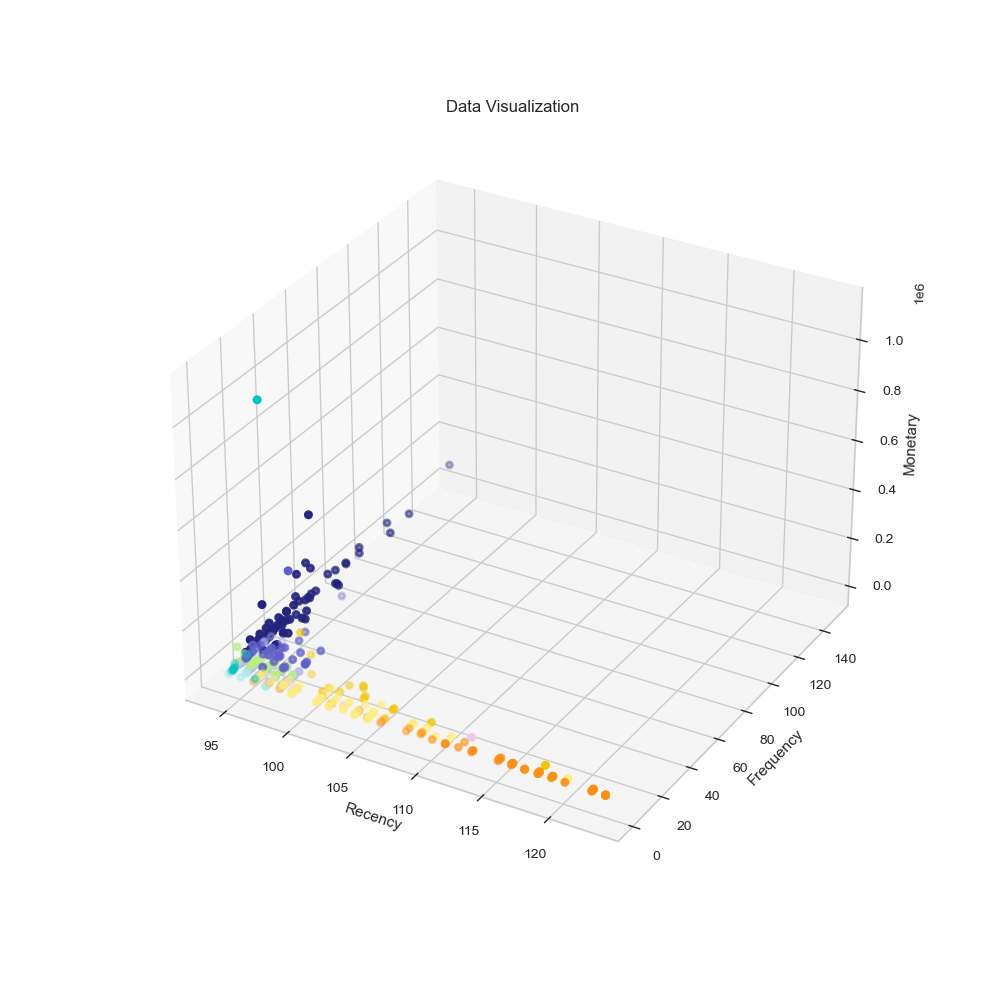

In [81]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
plt.title('Data Visualization')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

ax.scatter(xChampion, yChampion, zChampion, c='#23237C', linewidth=2);
ax.scatter(xLoyal, yLoyal, zLoyal, c='#6061C9', linewidth=2);
ax.scatter(xPoLoyal, yPoLoyal, zPoLoyal, c='#B5B8F9', linewidth=2);
ax.scatter(xNewCust, yNewCust, zNewCust, c='#ABEEEC', linewidth=2);
ax.scatter(xPromis, yPromis, zPromis, c='#01C4C3', linewidth=2);
ax.scatter(xNeedAttent, yNeedAttent, zNeedAttent, c='#B8F080', linewidth=2);
ax.scatter(xAbout, yAbout, zAbout, c='#FBC57E', linewidth=2);
ax.scatter(xrisk, yrisk, zrisk, c='#F4C500', linewidth=2);
ax.scatter(xCantlose, yCantlose, zCantlose, c='#EBC9EE', linewidth=2);
ax.scatter(xHibernate, yHibernate, zHibernate, c='#FFEE7C', linewidth=2);
ax.scatter(xLost, yLost, zLost, c='#FF9014', linewidth=2);

#### Rlog(F)log(M) Graph

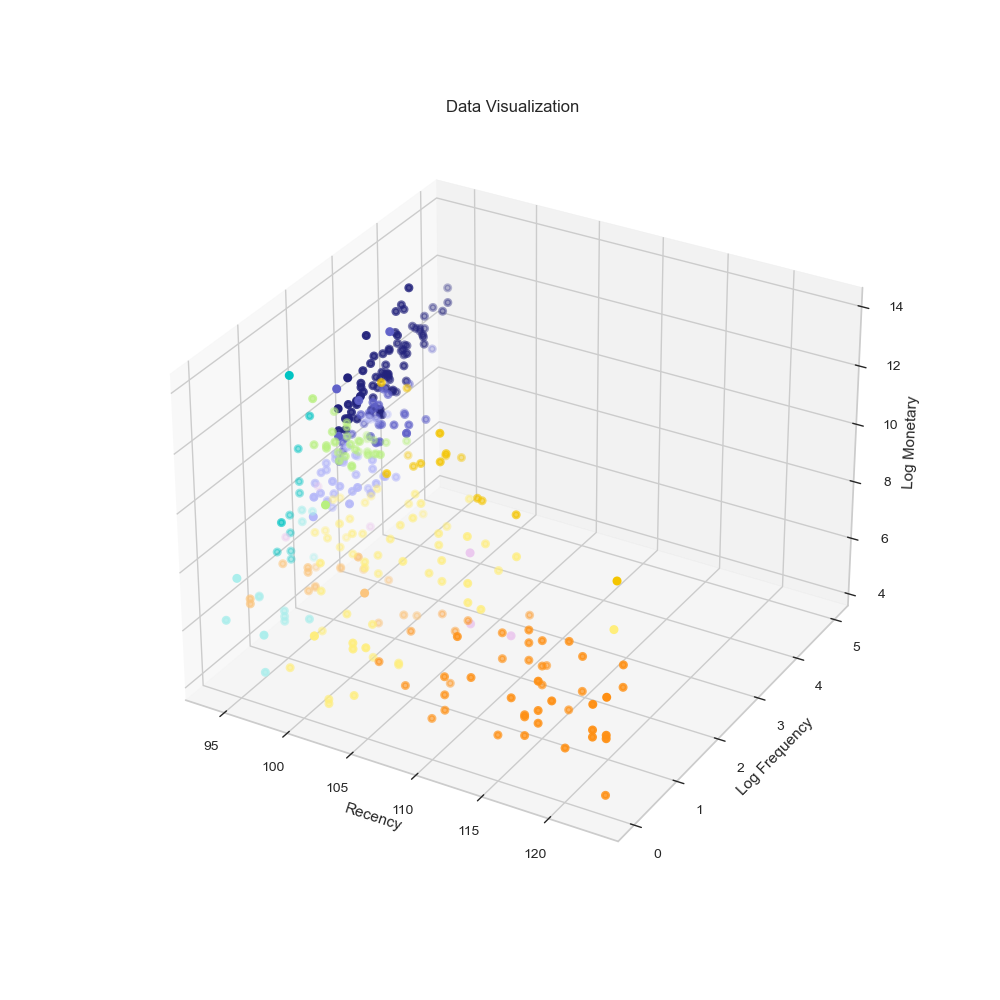

In [83]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

plt.title('Data Visualization')
ax.set_xlabel('Recency')
ax.set_ylabel('Log Frequency')
ax.set_zlabel('Log Monetary')

ax.scatter(xChampion, logyChampion, logzChampion, c='#23237C', linewidth=2);
ax.scatter(xLoyal, logyLoyal, logzLoyal, c='#6061C9', linewidth=2);
ax.scatter(xPoLoyal, logyPoLoyal, logzPoLoyal, c='#B5B8F9', linewidth=2);
ax.scatter(xNewCust, logyNewCust, logzNewCust, c='#ABEEEC', linewidth=2);
ax.scatter(xPromis, logyPromis, logzPromis, c='#01C4C3', linewidth=2);
ax.scatter(xNeedAttent, logyNeedAttent, logzNeedAttent, c='#B8F080', linewidth=2);
ax.scatter(xAbout, logyAbout, logzAbout, c='#FBC57E', linewidth=2);
ax.scatter(xrisk, logyrisk, logzrisk, c='#F4C500', linewidth=2);
ax.scatter(xCantlose, logyCantlose, logzCantlose, c='#EBC9EE', linewidth=2);
ax.scatter(xHibernate, logyHibernate, logzHibernate, c='#FFEE7C', linewidth=2);
ax.scatter(xLost, logyLost, logzLost, c='#FF9014', linewidth=2);

#### RF Graph

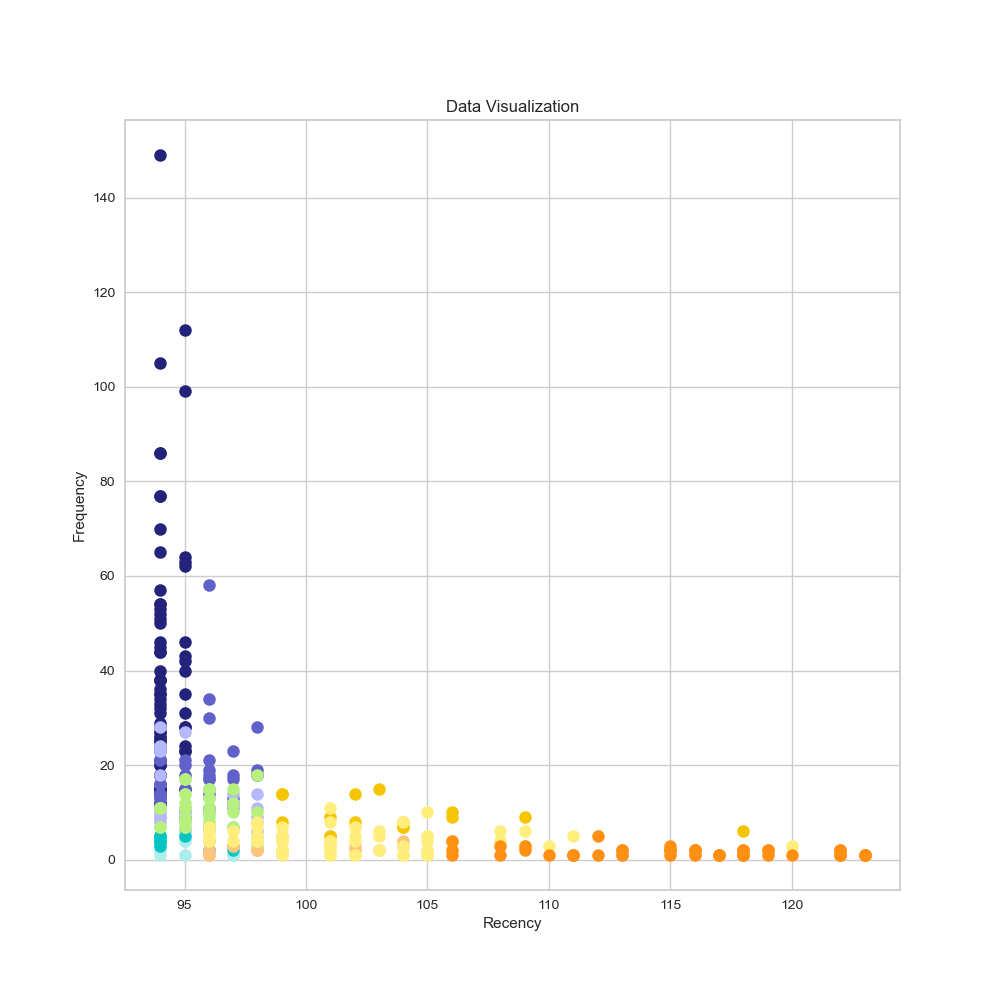

In [84]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

plt.title('Data Visualization')
ax.set_ylabel('Frequency')
ax.set_xlabel('Recency')


ax.scatter(xChampion, yChampion,  c='#23237C', linewidth=2);
ax.scatter(xLoyal, yLoyal,  c='#6061C9', linewidth=2);
ax.scatter(xPoLoyal, yPoLoyal,  c='#B5B8F9', linewidth=2);
ax.scatter(xNewCust, yNewCust,  c='#ABEEEC', linewidth=2);
ax.scatter(xPromis, yPromis,  c='#01C4C3', linewidth=2);
ax.scatter(xNeedAttent, yNeedAttent,  c='#B8F080', linewidth=2);
ax.scatter(xAbout, yAbout,  c='#FBC57E', linewidth=2);
ax.scatter(xrisk, yrisk,  c='#F4C500', linewidth=2);
ax.scatter(xCantlose, yCantlose,  c='#EBC9EE', linewidth=2);
ax.scatter(xHibernate, yHibernate,  c='#FFEE7C', linewidth=2);
ax.scatter(xLost, yLost,  c='#FF9014', linewidth=2);

#### Rlog(F) Graph

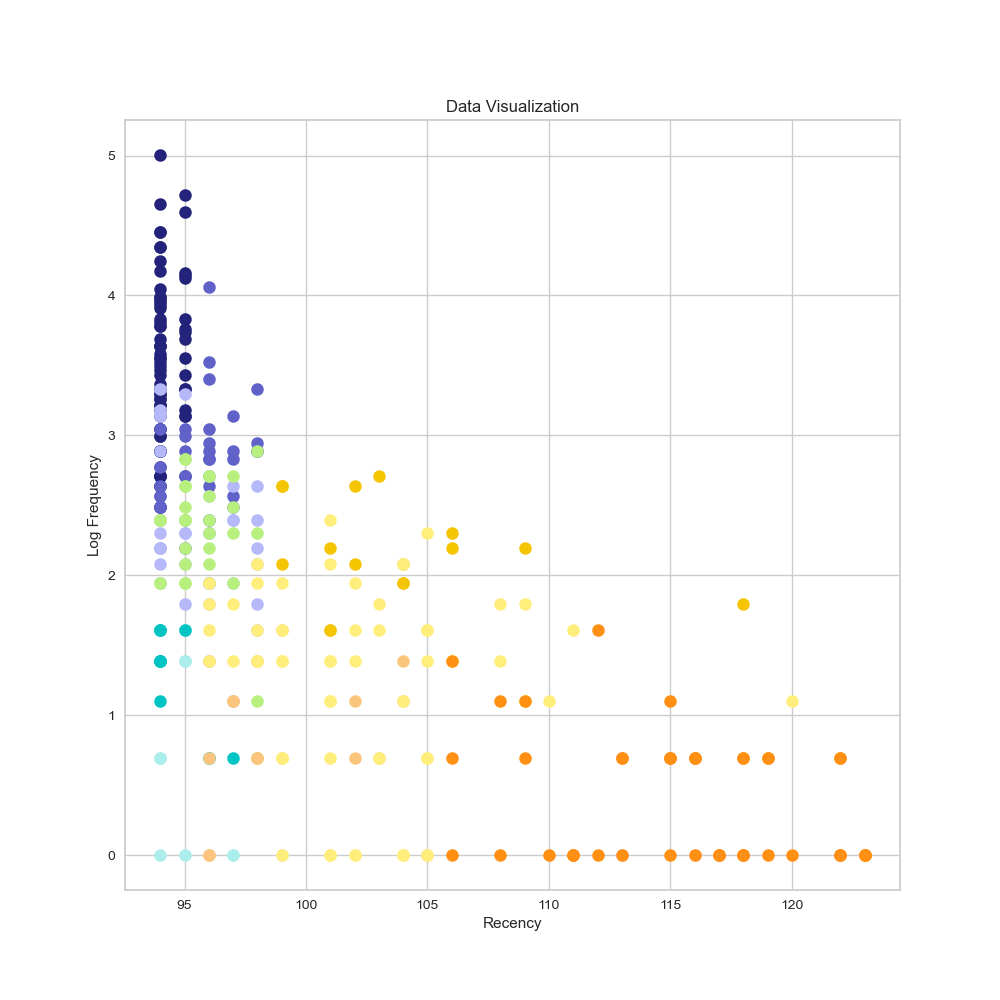

In [85]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()


plt.title('Data Visualization')
ax.set_ylabel('Log Frequency')
ax.set_xlabel('Recency')


ax.scatter(xChampion, logyChampion,  c='#23237C', linewidth=2);
ax.scatter(xLoyal, logyLoyal,  c='#6061C9', linewidth=2);
ax.scatter(xPoLoyal, logyPoLoyal,  c='#B5B8F9', linewidth=2);
ax.scatter(xNewCust, logyNewCust,  c='#ABEEEC', linewidth=2);
ax.scatter(xPromis, logyPromis,  c='#01C4C3', linewidth=2);
ax.scatter(xNeedAttent, logyNeedAttent,  c='#B8F080', linewidth=2);
ax.scatter(xAbout, logyAbout,  c='#FBC57E', linewidth=2);
ax.scatter(xrisk, logyrisk,  c='#F4C500', linewidth=2);
ax.scatter(xCantlose, logyCantlose,  c='#EBC9EE', linewidth=2);
ax.scatter(xHibernate, logyHibernate,  c='#FFEE7C', linewidth=2);
ax.scatter(xLost, logyLost,  c='#FF9014', linewidth=2);

#### RM Graph

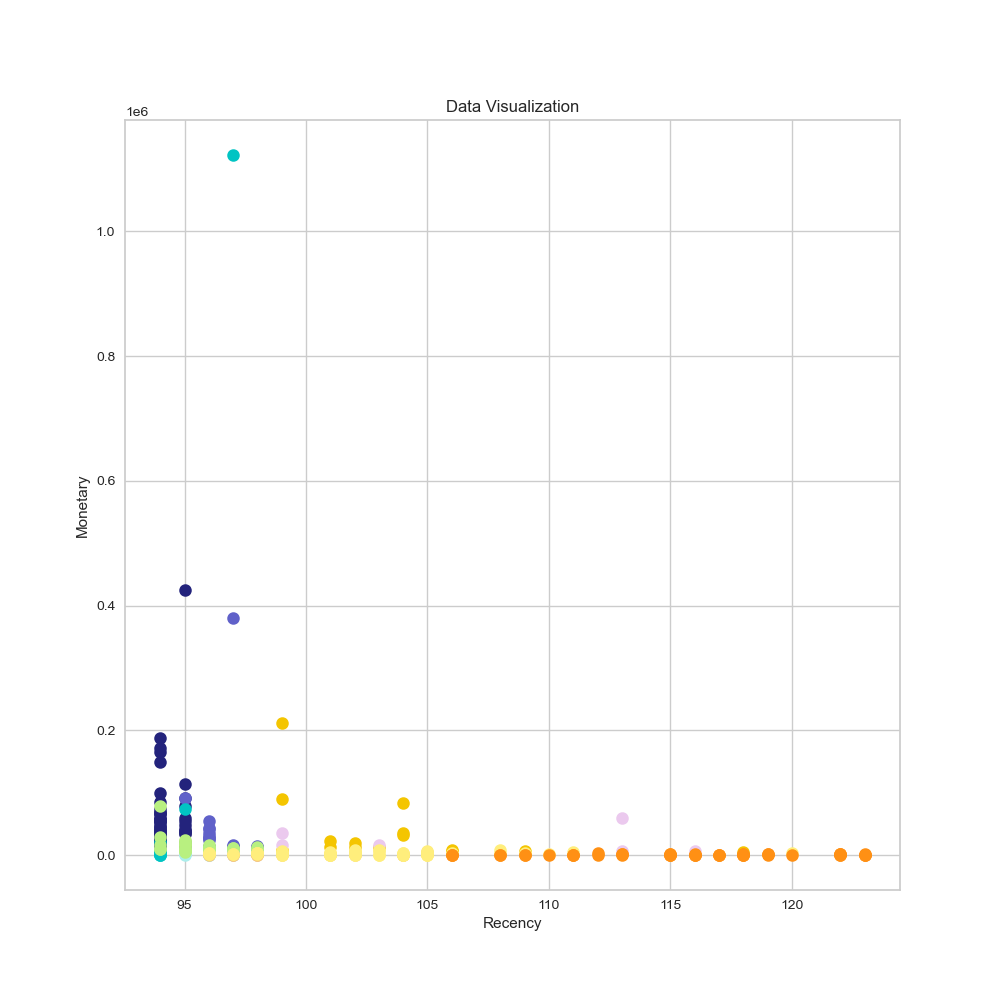

In [86]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

plt.title('Data Visualization')
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')

ax.scatter( xChampion, zChampion, c='#23237C', linewidth=2);
ax.scatter( xLoyal, zLoyal, c='#6061C9', linewidth=2);
ax.scatter( xPoLoyal, zPoLoyal, c='#B5B8F9', linewidth=2);
ax.scatter( xNewCust, zNewCust, c='#ABEEEC', linewidth=2);
ax.scatter( xPromis, zPromis, c='#01C4C3', linewidth=2);
ax.scatter( xNeedAttent, zNeedAttent, c='#B8F080', linewidth=2);
ax.scatter( xAbout, zAbout, c='#FBC57E', linewidth=2);
ax.scatter( xrisk, zrisk, c='#F4C500', linewidth=2);
ax.scatter( xCantlose, zCantlose, c='#EBC9EE', linewidth=2);
ax.scatter( xHibernate, zHibernate, c='#FFEE7C', linewidth=2);
ax.scatter( xLost, zLost, c='#FF9014', linewidth=2);

#### Rlog(M) Graph

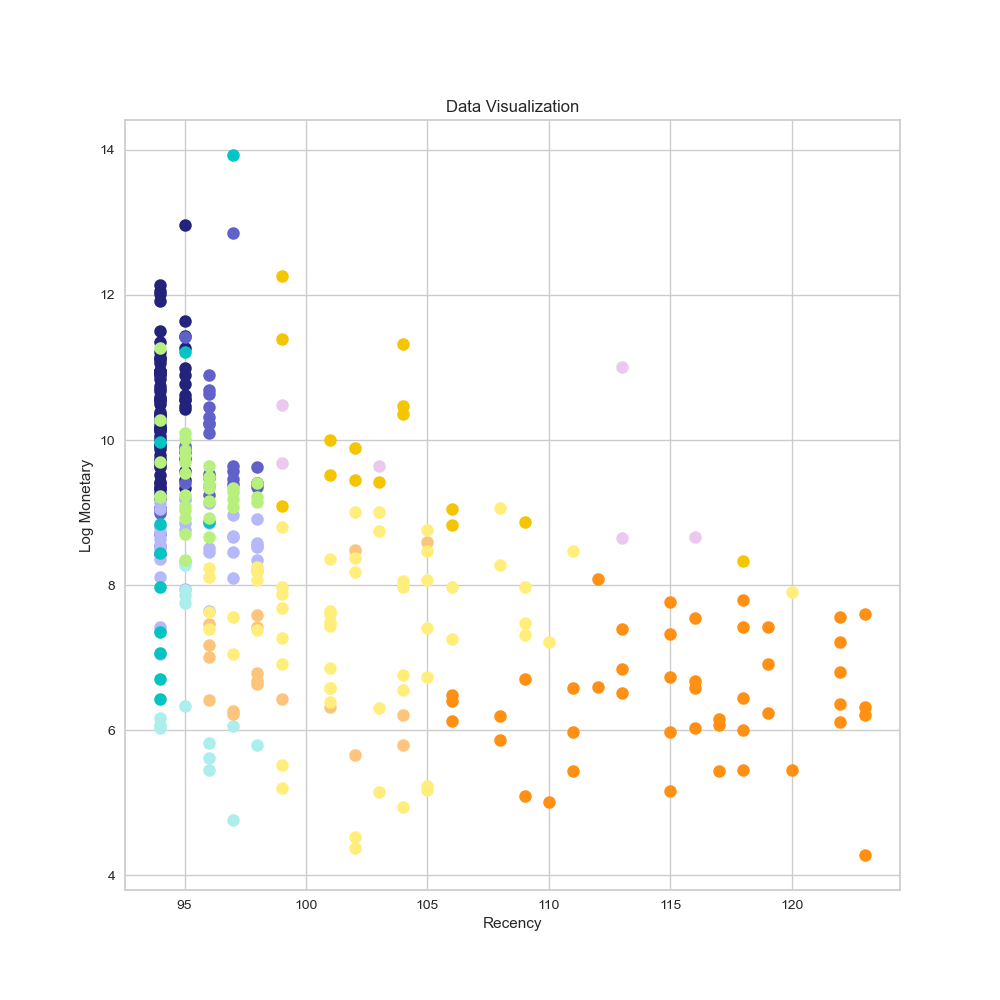

In [87]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

plt.title('Data Visualization')
ax.set_xlabel('Recency')
ax.set_ylabel('Log Monetary')

ax.scatter( xChampion, logzChampion, c='#23237C', linewidth=2);
ax.scatter( xLoyal, logzLoyal, c='#6061C9', linewidth=2);
ax.scatter( xPoLoyal, logzPoLoyal, c='#B5B8F9', linewidth=2);
ax.scatter( xNewCust, logzNewCust, c='#ABEEEC', linewidth=2);
ax.scatter( xPromis, logzPromis, c='#01C4C3', linewidth=2);
ax.scatter( xNeedAttent, logzNeedAttent, c='#B8F080', linewidth=2);
ax.scatter( xAbout, logzAbout, c='#FBC57E', linewidth=2);
ax.scatter( xrisk, logzrisk, c='#F4C500', linewidth=2);
ax.scatter( xCantlose, logzCantlose, c='#EBC9EE', linewidth=2);
ax.scatter( xHibernate, logzHibernate, c='#FFEE7C', linewidth=2);
ax.scatter( xLost, logzLost, c='#FF9014', linewidth=2);

#### FM Graph

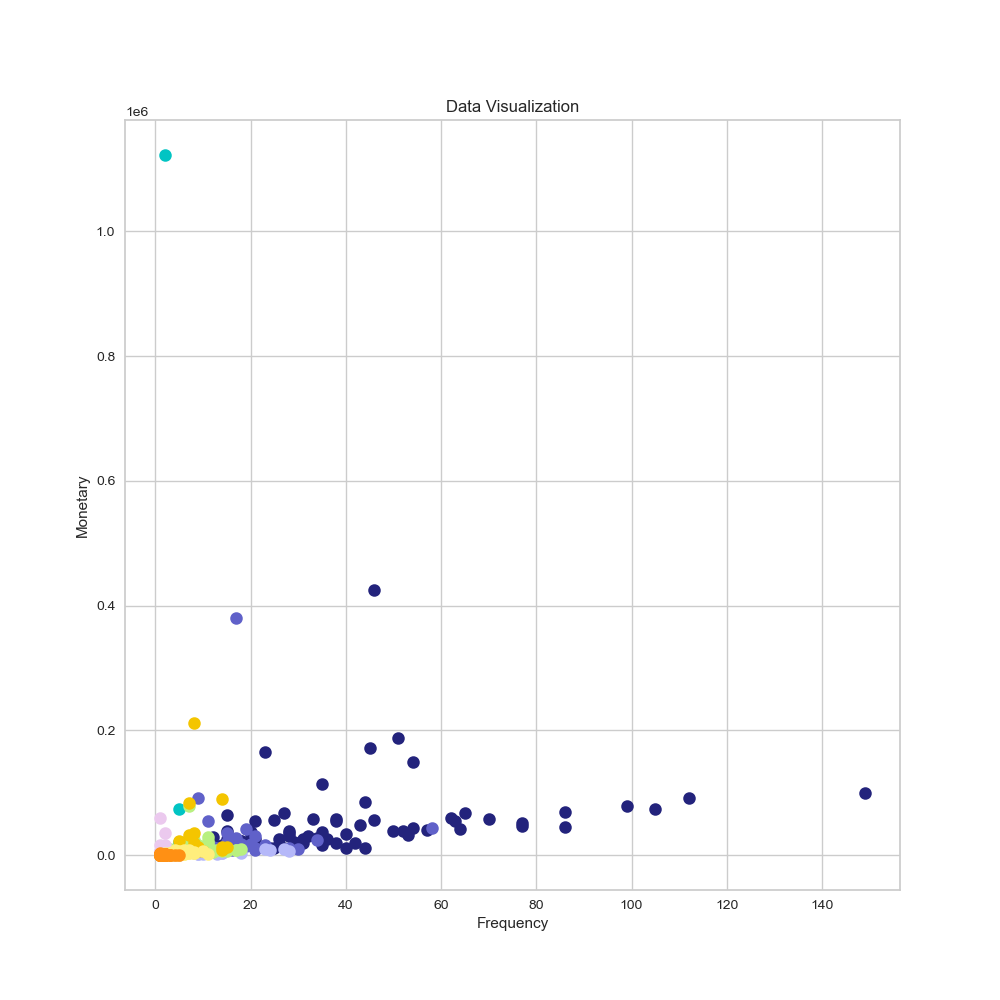

In [88]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

plt.title('Data Visualization')
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')

ax.scatter(yChampion,  zChampion, c='#23237C', linewidth=2);
ax.scatter(yLoyal,  zLoyal, c='#6061C9', linewidth=2);
ax.scatter(yPoLoyal,  zPoLoyal, c='#B5B8F9', linewidth=2);
ax.scatter(yNewCust,  zNewCust, c='#ABEEEC', linewidth=2);
ax.scatter(yPromis,  zPromis, c='#01C4C3', linewidth=2);
ax.scatter(yNeedAttent,  zNeedAttent, c='#B8F080', linewidth=2);
ax.scatter(yAbout,  zAbout, c='#FBC57E', linewidth=2);
ax.scatter(yrisk,  zrisk, c='#F4C500', linewidth=2);
ax.scatter(yCantlose,  zCantlose, c='#EBC9EE', linewidth=2);
ax.scatter(yHibernate,  zHibernate, c='#FFEE7C', linewidth=2);
ax.scatter(yLost,  zLost, c='#FF9014', linewidth=2);

#### log(F)log(M) Graph

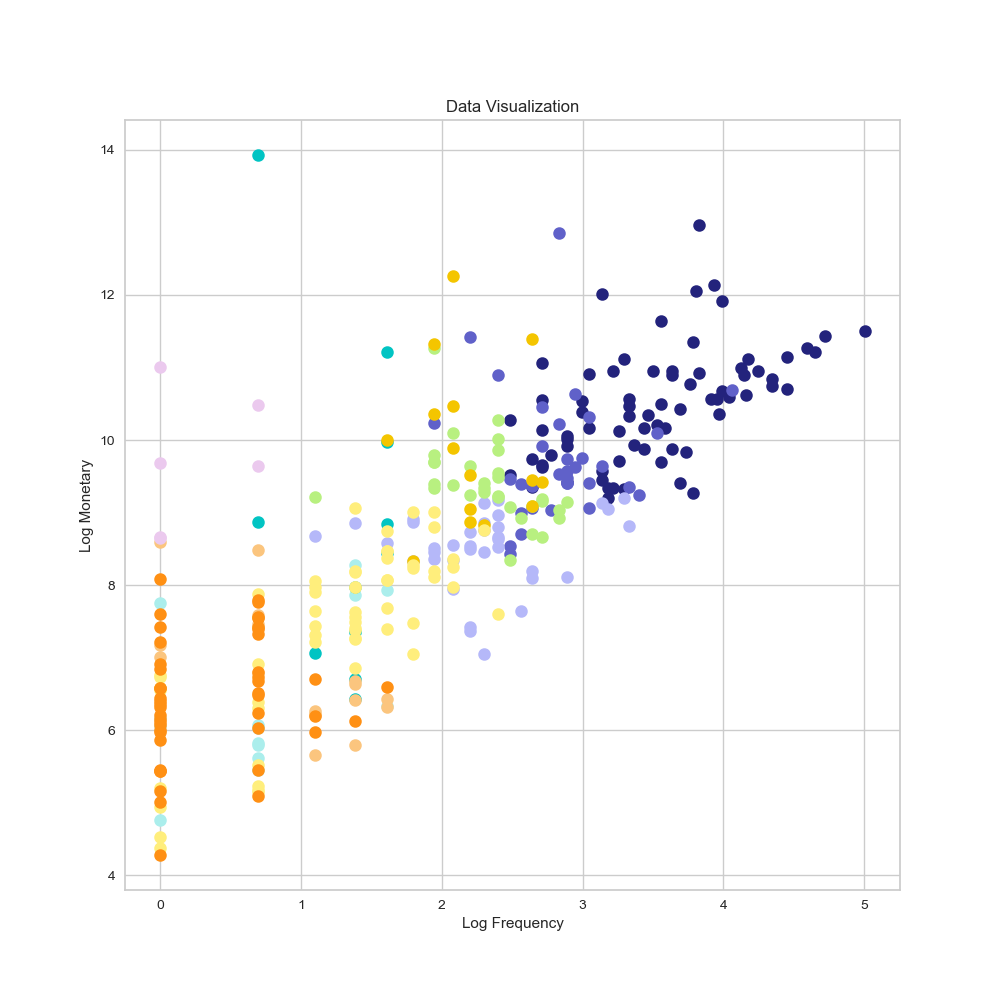

In [89]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

plt.title('Data Visualization')
ax.set_xlabel('Log Frequency')
ax.set_ylabel('Log Monetary')

ax.scatter(logyChampion, logzChampion, c='#23237C', linewidth=2);
ax.scatter(logyLoyal, logzLoyal, c='#6061C9', linewidth=2);
ax.scatter(logyPoLoyal, logzPoLoyal, c='#B5B8F9', linewidth=2);
ax.scatter(logyNewCust, logzNewCust, c='#ABEEEC', linewidth=2);
ax.scatter(logyPromis, logzPromis, c='#01C4C3', linewidth=2);
ax.scatter(logyNeedAttent, logzNeedAttent, c='#B8F080', linewidth=2);
ax.scatter(logyAbout, logzAbout, c='#FBC57E', linewidth=2);
ax.scatter(logyrisk, logzrisk, c='#F4C500', linewidth=2);
ax.scatter(logyCantlose, logzCantlose, c='#EBC9EE', linewidth=2);
ax.scatter(logyHibernate, logzHibernate, c='#FFEE7C', linewidth=2);
ax.scatter(logyLost, logzLost, c='#FF9014', linewidth=2);

#### RFM Mean

In [90]:
segmented_rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3           115.6       1.3    450.3    27
4           109.9       1.8    989.4    34
5           103.7       2.7   1521.6    21
6           101.0       3.4   2348.2    28
7           100.8       4.6   6817.5    24
8            98.0       5.6   6815.4    20
9            97.0       8.3  54683.9    23
10           97.2      10.1  19933.9    29
11           95.5      12.1  17571.6    33
12           95.1      17.8  33198.5    25
13           94.4      21.2  20901.5    22
14           94.4      37.8  51437.8    28
15           94.0      53.4  66196.8    30

In [113]:
segmented_rfm

Year Month CalendarDay  Customer_ID  Recency  Frequency    Monetary  \
0    2021    10  2021-10-30            1       94         30    21276.23   
1    2021    10  2021-10-30            2       94         19    23436.00   
2    2021    10  2021-10-26            3       98          8     7684.00   
3    2021    10  2021-10-29            4       95          7   100902.08   
4    2021    10  2021-10-30            5       94        125    78317.55   
5    2021    10  2021-10-18            8      106          4     2900.00   
6    2021    10  2021-10-04            9      120          4     4052.79   
7    2021    10  2021-10-28           10       96         15    88244.00   
8    2021    10  2021-10-25           13       99          2     2640.00   
9    2021    10  2021-10-25           14       99         19   219270.80   
10   2021    10  2021-10-25           15       99          4     2910.00   
11   2021    10  2021-10-23           16      101          1     2702.80   
12   2021    10  2021-10-11           17      113          3    25813.20   
13   2021    10  2021-10-29           18       95          8    13499.50   
14   2021    10  2021-10-27           19       97          7    11390.00   
15   2021    10  2021-10-27           20       97         12    17247.67   
16   2021    10  2021-10-30           22       94         27    67166.00   
17   2021    10  2021-10-30           23       94         55    45913.92   
18   2021    10  2021-10-26           24       98          2     1980.00   
19   2021    10  2021-10-23           25      101          2     2040.00   
20   2021    10  2021-10-19           28      105          2      176.00   
21   2021    10  2021-10-26           29       98         10    12381.00   
22   2021    10  2021-10-21           31      103          5     6272.30   
23   2021    10  2021-10-30           32       94         18    16271.27   
24   2021    10  2021-10-18           34      106         10     6819.00   
25   2021    10  2021-10-19           35      105          1     5400.00   
26   2021    10  2021-10-30           36       94         21    21494.18   
27   2021    10  2021-10-30           39       94         17     1998.88   
28   2021    10  2021-10-30           40       94         28    30875.00   
29   2021    10  2021-10-28           41       96         23    42060.00   
30   2021    10  2021-10-28           42       96          3      322.71   
31   2021    10  2021-10-02           44      122          3    10470.00   
32   2021    10  2021-10-29           45       95          7    17832.00   
33   2021    10  2021-10-28           46       96         16    66520.00   
34   2021    10  2021-10-30           47       94         23    40495.34   
35   2021    10  2021-10-22           49      102          4      385.52   
36   2021    10  2021-10-18           50      106          2      650.00   
37   2021    10  2021-10-13           52      111          2     1579.44   
38   2021    10  2021-10-30           55       94         58    51638.95   
39   2021    10  2021-10-29           56       95         42    18645.00   
40   2021    10  2021-10-30           58       94        156   104347.95   
41   2021    10  2021-10-28           59       96          7     3318.00   
42   2021    10  2021-10-28           62       96          7    15788.00   
43   2021    10  2021-10-28           63       96         10     9250.00   
44   2021    10  2021-10-07           65      117          1    21532.71   
45   2021    10  2021-10-29           66       95         14   105320.00   
46   2021    10  2021-10-25           67       99          4     1074.16   
47   2021    10  2021-10-30           70       94          6    12234.40   
48   2021    10  2021-10-30           71       94         63   191509.66   
49   2021    10  2021-10-09           75      115          6      544.57   
50   2021    10  2021-10-26           76       98         14    66428.86   
51   2021    10  2021-10-29           77       95    

## Regression

In [114]:
segmented_rfm

Year Month CalendarDay  Customer_ID  Recency  Frequency    Monetary  \
0    2021    10  2021-10-30            1       94         30    21276.23   
1    2021    10  2021-10-30            2       94         19    23436.00   
2    2021    10  2021-10-26            3       98          8     7684.00   
3    2021    10  2021-10-29            4       95          7   100902.08   
4    2021    10  2021-10-30            5       94        125    78317.55   
5    2021    10  2021-10-18            8      106          4     2900.00   
6    2021    10  2021-10-04            9      120          4     4052.79   
7    2021    10  2021-10-28           10       96         15    88244.00   
8    2021    10  2021-10-25           13       99          2     2640.00   
9    2021    10  2021-10-25           14       99         19   219270.80   
10   2021    10  2021-10-25           15       99          4     2910.00   
11   2021    10  2021-10-23           16      101          1     2702.80   
12   2021    10  2021-10-11           17      113          3    25813.20   
13   2021    10  2021-10-29           18       95          8    13499.50   
14   2021    10  2021-10-27           19       97          7    11390.00   
15   2021    10  2021-10-27           20       97         12    17247.67   
16   2021    10  2021-10-30           22       94         27    67166.00   
17   2021    10  2021-10-30           23       94         55    45913.92   
18   2021    10  2021-10-26           24       98          2     1980.00   
19   2021    10  2021-10-23           25      101          2     2040.00   
20   2021    10  2021-10-19           28      105          2      176.00   
21   2021    10  2021-10-26           29       98         10    12381.00   
22   2021    10  2021-10-21           31      103          5     6272.30   
23   2021    10  2021-10-30           32       94         18    16271.27   
24   2021    10  2021-10-18           34      106         10     6819.00   
25   2021    10  2021-10-19           35      105          1     5400.00   
26   2021    10  2021-10-30           36       94         21    21494.18   
27   2021    10  2021-10-30           39       94         17     1998.88   
28   2021    10  2021-10-30           40       94         28    30875.00   
29   2021    10  2021-10-28           41       96         23    42060.00   
30   2021    10  2021-10-28           42       96          3      322.71   
31   2021    10  2021-10-02           44      122          3    10470.00   
32   2021    10  2021-10-29           45       95          7    17832.00   
33   2021    10  2021-10-28           46       96         16    66520.00   
34   2021    10  2021-10-30           47       94         23    40495.34   
35   2021    10  2021-10-22           49      102          4      385.52   
36   2021    10  2021-10-18           50      106          2      650.00   
37   2021    10  2021-10-13           52      111          2     1579.44   
38   2021    10  2021-10-30           55       94         58    51638.95   
39   2021    10  2021-10-29           56       95         42    18645.00   
40   2021    10  2021-10-30           58       94        156   104347.95   
41   2021    10  2021-10-28           59       96          7     3318.00   
42   2021    10  2021-10-28           62       96          7    15788.00   
43   2021    10  2021-10-28           63       96         10     9250.00   
44   2021    10  2021-10-07           65      117          1    21532.71   
45   2021    10  2021-10-29           66       95         14   105320.00   
46   2021    10  2021-10-25           67       99          4     1074.16   
47   2021    10  2021-10-30           70       94          6    12234.40   
48   2021    10  2021-10-30           71       94         63   191509.66   
49   2021    10  2021-10-09           75      115          6      544.57   
50   2021    10  2021-10-26           76       98         14    66428.86   
51   2021    10  2021-10-29           77       95    

In [115]:
train_test_data = segmented_rfm.copy()
train_test_data.drop(columns=['Customer_ID','FM_Avg','R_Score','F_Score','M_Score','FM_Score','RFM_Segment','RFM_Score'],inplace=True)
train_test_data

Year Month CalendarDay  Recency  Frequency    Monetary            Class
0    2021    10  2021-10-30       94         30    21276.23         Champion
1    2021    10  2021-10-30       94         19    23436.00         Champion
2    2021    10  2021-10-26       98          8     7684.00  Potential Loyal
3    2021    10  2021-10-29       95          7   100902.08            Loyal
4    2021    10  2021-10-30       94        125    78317.55         Champion
5    2021    10  2021-10-18      106          4     2900.00      Hibernating
6    2021    10  2021-10-04      120          4     4052.79      Hibernating
7    2021    10  2021-10-28       96         15    88244.00            Loyal
8    2021    10  2021-10-25       99          2     2640.00      Hibernating
9    2021    10  2021-10-25       99         19   219270.80          At risk
10   2021    10  2021-10-25       99          4     2910.00      Hibernating
11   2021    10  2021-10-23      101          1     2702.80      Hibernating
12   2021    10  2021-10-11      113          3    25813.20          At risk
13   2021    10  2021-10-29       95          8    13499.50   Need Attention
14   2021    10  2021-10-27       97          7    11390.00  Potential Loyal
15   2021    10  2021-10-27       97         12    17247.67            Loyal
16   2021    10  2021-10-30       94         27    67166.00         Champion
17   2021    10  2021-10-30       94         55    45913.92         Champion
18   2021    10  2021-10-26       98          2     1980.00   About to sleep
19   2021    10  2021-10-23      101          2     2040.00      Hibernating
20   2021    10  2021-10-19      105          2      176.00      Hibernating
21   2021    10  2021-10-26       98         10    12381.00  Potential Loyal
22   2021    10  2021-10-21      103          5     6272.30      Hibernating
23   2021    10  2021-10-30       94         18    16271.27         Champion
24   2021    10  2021-10-18      106         10     6819.00          At risk
25   2021    10  2021-10-19      105          1     5400.00   About to sleep
26   2021    10  2021-10-30       94         21    21494.18         Champion
27   2021    10  2021-10-30       94         17     1998.88  Potential Loyal
28   2021    10  2021-10-30       94         28    30875.00         Champion
29   2021    10  2021-10-28       96         23    42060.00            Loyal
30   2021    10  2021-10-28       96          3      322.71   About to sleep
31   2021    10  2021-10-02      122          3    10470.00      Hibernating
32   2021    10  2021-10-29       95          7    17832.00   Need Attention
33   2021    10  2021-10-28       96         16    66520.00            Loyal
34   2021    10  2021-10-30       94         23    40495.34         Champion
35   2021    10  2021-10-22      102          4      385.52   About to sleep
36   2021    10  2021-10-18      106          2      650.00             Lost
37   2021    10  2021-10-13      111          2     1579.44             Lost
38   2021    10  2021-10-30       94         58    51638.95         Champion
39   2021    10  2021-10-29       95         42    18645.00         Champion
40   2021    10  2021-10-30       94        156   104347.95         Champion
41   2021    10  2021-10-28       96          7     3318.00      Hibernating
42   2021    10  2021-10-28       96          7    15788.00   Need Attention
43   2021    10  2021-10-28       96         10     9250.00  Potential Loyal
44   2021    10  2021-10-07      117          1    21532.71  Can't lose them
45   2021    10  2021-10-29       95         14   105320.00         Champion
46   2021    10  2021-10-25       99          4     1074.16   About to sleep
47   2021    10  2021-10-30       94          6    12234.40  Potential Loyal
48   2021    10  2021-10-30       94         63   191509.66         Champion
49   2021    10  2021-10-09      115          6      544.57             Lost
50   2021    10  2021-10-26       98         14    66428.86            Loyal
5

In [116]:
# Champion > Loyal > Potential Loyal > 	New Customer > Promising > 	Need Attention > About to sleep > At risk	 > Can't lose them > Hibernating > Lost
train_test_data['Class'] = train_test_data['Class'].replace({'Champion':10, 'Loyal':9,'Potential Loyal':8,'New Customer':7,'Promising':6,'Need Attention':5,'About to sleep':4,'At risk':3,"Can't lose them":2,'Hibernating':1,'Lost':0})
train_test_data

Year Month CalendarDay  Recency  Frequency    Monetary  Class
0    2021    10  2021-10-30       94         30    21276.23     10
1    2021    10  2021-10-30       94         19    23436.00     10
2    2021    10  2021-10-26       98          8     7684.00      8
3    2021    10  2021-10-29       95          7   100902.08      9
4    2021    10  2021-10-30       94        125    78317.55     10
5    2021    10  2021-10-18      106          4     2900.00      1
6    2021    10  2021-10-04      120          4     4052.79      1
7    2021    10  2021-10-28       96         15    88244.00      9
8    2021    10  2021-10-25       99          2     2640.00      1
9    2021    10  2021-10-25       99         19   219270.80      3
10   2021    10  2021-10-25       99          4     2910.00      1
11   2021    10  2021-10-23      101          1     2702.80      1
12   2021    10  2021-10-11      113          3    25813.20      3
13   2021    10  2021-10-29       95          8    13499.50      5
14   2021    10  2021-10-27       97          7    11390.00      8
15   2021    10  2021-10-27       97         12    17247.67      9
16   2021    10  2021-10-30       94         27    67166.00     10
17   2021    10  2021-10-30       94         55    45913.92     10
18   2021    10  2021-10-26       98          2     1980.00      4
19   2021    10  2021-10-23      101          2     2040.00      1
20   2021    10  2021-10-19      105          2      176.00      1
21   2021    10  2021-10-26       98         10    12381.00      8
22   2021    10  2021-10-21      103          5     6272.30      1
23   2021    10  2021-10-30       94         18    16271.27     10
24   2021    10  2021-10-18      106         10     6819.00      3
25   2021    10  2021-10-19      105          1     5400.00      4
26   2021    10  2021-10-30       94         21    21494.18     10
27   2021    10  2021-10-30       94         17     1998.88      8
28   2021    10  2021-10-30       94         28    30875.00     10
29   2021    10  2021-10-28       96         23    42060.00      9
30   2021    10  2021-10-28       96          3      322.71      4
31   2021    10  2021-10-02      122          3    10470.00      1
32   2021    10  2021-10-29       95          7    17832.00      5
33   2021    10  2021-10-28       96         16    66520.00      9
34   2021    10  2021-10-30       94         23    40495.34     10
35   2021    10  2021-10-22      102          4      385.52      4
36   2021    10  2021-10-18      106          2      650.00      0
37   2021    10  2021-10-13      111          2     1579.44      0
38   2021    10  2021-10-30       94         58    51638.95     10
39   2021    10  2021-10-29       95         42    18645.00     10
40   2021    10  2021-10-30       94        156   104347.95     10
41   2021    10  2021-10-28       96          7     3318.00      1
42   2021    10  2021-10-28       96          7    15788.00      5
43   2021    10  2021-10-28       96         10     9250.00      8
44   2021    10  2021-10-07      117          1    21532.71      2
45   2021    10  2021-10-29       95         14   105320.00     10
46   2021    10  2021-10-25       99          4     1074.16      4
47   2021    10  2021-10-30       94          6    12234.40      8
48   2021    10  2021-10-30       94         63   191509.66     10
49   2021    10  2021-10-09      115          6      544.57      0
50   2021    10  2021-10-26       98         14    66428.86      9
51   2021    10  2021-10-29       95         28    35233.00     10
52   2021    10  2021-10-22      102          3      829.67      4
53   2021    10  2021-10-23      101          5    10594.10      1
54   2021    10  2021-10-25       99          5      619.68      4
55   2021    10  2021-10-29       95         10   105404.23      9
56   2021    10  2021-10-09      115          2      840.00      0
57   2021    10  2021-10-26       98          5     3190.00      1
58   2021    10  2021-10-28       96         15     

In [117]:
# split X and y into training and testing sets

# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
train_data,test_data=train_test_split(train_test_data,test_size=0.3,random_state=0)

In [118]:
train_data.shape

(329, 7)

In [119]:
test_data.shape

(141, 7)

In [120]:
# setup
reg = setup(data = train_test_data, target = 'Class', fold_shuffle=True, imputation_type='iterative')

AttributeError: 'Make_Time_Features' object has no attribute 'list_of_features'

In [43]:
# all the models that are available are 
models()

Name  \
ID                                            
lr                        Linear Regression   
lasso                      Lasso Regression   
ridge                      Ridge Regression   
en                              Elastic Net   
lar                  Least Angle Regression   
llar           Lasso Least Angle Regression   
omp             Orthogonal Matching Pursuit   
br                           Bayesian Ridge   
ard       Automatic Relevance Determination   
par            Passive Aggressive Regressor   
ransac              Random Sample Consensus   
tr                       TheilSen Regressor   
huber                       Huber Regressor   
kr                             Kernel Ridge   
svm               Support Vector Regression   
knn                   K Neighbors Regressor   
dt                  Decision Tree Regressor   
rf                  Random Forest Regressor   
et                    Extra Trees Regressor   
ada                      AdaBoost Regressor   
gbr             Gradient Boosting Regressor   
mlp                           MLP Regressor   
xgboost           Extreme Gradient Boosting   
lightgbm    Light Gradient Boosting Machine   
catboost                 CatBoost Regressor   

                                                  Reference  Turbo  
ID                                                                  
lr              sklearn.linear_model._base.LinearRegression   True  
lasso        sklearn.linear_model._coordinate_descent.Lasso   True  
ridge                     sklearn.linear_model._ridge.Ridge   True  
en        sklearn.linear_model._coordinate_descent.Elast...   True  
lar                  sklearn.linear_model._least_angle.Lars   True  
llar            sklearn.linear_model._least_angle.LassoLars   True  
omp       sklearn.linear_model._omp.OrthogonalMatchingPu...   True  
br                sklearn.linear_model._bayes.BayesianRidge   True  
ard               sklearn.linear_model._bayes.ARDRegression  False  
par       sklearn.linear_model._passive_aggressive.Passi...   True  
ransac         sklearn.linear_model._ransac.RANSACRegressor  False  
tr        sklearn.linear_model._theil_sen.TheilSenRegressor  False  
huber            sklearn.linear_model._huber.HuberRegressor   True  
kr                         sklearn.kernel_ridge.KernelRidge  False  
svm                                sklearn.svm._classes.SVR  False  
knn       sklearn.neighbors._regression.KNeighborsRegressor   True  
dt              sklearn.tree._classes.DecisionTreeRegressor   True  
rf           sklearn.ensemble._forest.RandomForestRegressor   True  
et             sklearn.ensemble._forest.ExtraTreesRegressor   True  
ada       sklearn.ensemble._weight_boosting.AdaBoostRegr...   True  
gbr          sklearn.ensemble._gb.GradientBoostingRegressor   True  
mlp            pycaret.internal.tunable.TunableMLPRegressor  False  
xgboost                        xgboost.sklearn.XGBRegressor   True  
lightgbm                     lightgbm.sklearn.LGBMRegressor   True  
catboost                    catboost.core.CatBoostRegressor   True

In [44]:
best = compare_models(fold = 5, turbo = True)

In [45]:
best

In [46]:
best_model = create_model(best)

In [47]:
best_model

In [48]:
tuned_model = tune_model(best_model)

In [49]:
tuned_model

In [50]:
plot_model(tuned_model)

IntProgress(value=0, description='Processing: ', max=5)

TypeError: unsupported operand type(s) for -: 'float' and 'str'

In [ ]:
plot_model(tuned_model, plot = 'error')

In [ ]:
plot_model(tuned_model, plot = 'feature')

In [ ]:
evaluate_model(tuned_model)

In [ ]:
predict_model(tuned_model)

In [ ]:
final_model = finalize_model(tuned_model)
final_model

In [ ]:
predict_model(final_model)

In [ ]:
prediction = predict_model(final_model, data = test_data)
prediction

In [ ]:
save_model(final_model, 'Final_Model')

In [ ]:
# loaded_model = load_model('Final_Model')
# print(loaded_model)

## Churn Monitoring

In [ ]:
churn_monitor = prediction.copy()
churn_monitor = churn_monitor.rename(columns = {'Class': 'Old_Class', 'Label': 'Predict_Class'}, inplace = False)
churn_monitor

In [217]:
churn_monitor['Predict_Class'] = churn_monitor['Predict_Class'].round().astype('int')
churn_monitor

Recency  Frequency    Monetary  Old_Class  Predict_Class
540       39         13     7554.77          1              1
467        3        114  1278440.00         10             10
355        6          3     2699.28          4              4
172       45          3     2618.21          1              1
637        1         47     9273.79          9              8
..       ...        ...         ...        ...            ...
676       34         13     1767.16          1              1
263        6        138   669840.00          9              9
463       96          4      606.99          0              0
267        1         63    87709.99         10             10
159        7         20    13132.20          8              8

[213 rows x 5 columns]

In [218]:
# Compare Class
churn_monitor['Monitor'] = (churn_monitor['Old_Class'] > churn_monitor['Predict_Class'])
churn_monitor['Monitor'] = churn_monitor['Monitor'].replace({True:'Churn', False:'Not_Churn'})
churn_monitor

Recency  Frequency    Monetary  Old_Class  Predict_Class    Monitor
540       39         13     7554.77          1              1  Not_Churn
467        3        114  1278440.00         10             10  Not_Churn
355        6          3     2699.28          4              4  Not_Churn
172       45          3     2618.21          1              1  Not_Churn
637        1         47     9273.79          9              8      Churn
..       ...        ...         ...        ...            ...        ...
676       34         13     1767.16          1              1  Not_Churn
263        6        138   669840.00          9              9  Not_Churn
463       96          4      606.99          0              0  Not_Churn
267        1         63    87709.99         10             10  Not_Churn
159        7         20    13132.20          8              8  Not_Churn

[213 rows x 6 columns]

In [219]:
# Churn
# Champion > Loyal > Potential Loyal > 	New Customer > Promising > 	Need Attention > About to sleep > At risk	 > Can't lose them > Hibernating > Lost

churn_monitor['Old_Class'] = churn_monitor['Old_Class'].replace({10:'Champion', 9:'Loyal', 8:'Potential Loyal', 7:'New Customer', 6:'Promising', 5:'Need Attention', 
                                                             4:'About to sleep', 3:'At risk', 2:"Can't lose them", 1:'Hibernating', 0:'Lost'})
churn_monitor['Predict_Class'] = churn_monitor['Predict_Class'].replace({10:'Champion', 9:'Loyal', 8:'Potential Loyal', 7:'New Customer', 6:'Promising', 5:'Need Attention', 
                                                             4:'About to sleep', 3:'At risk', 2:"Can't lose them", 1:'Hibernating', 0:'Lost'})
churn_monitor

Recency  Frequency  ...    Predict_Class    Monitor
540       39         13  ...      Hibernating  Not_Churn
467        3        114  ...         Champion  Not_Churn
355        6          3  ...   About to sleep  Not_Churn
172       45          3  ...      Hibernating  Not_Churn
637        1         47  ...  Potential Loyal      Churn
..       ...        ...  ...              ...        ...
676       34         13  ...      Hibernating  Not_Churn
263        6        138  ...            Loyal  Not_Churn
463       96          4  ...             Lost  Not_Churn
267        1         63  ...         Champion  Not_Churn
159        7         20  ...  Potential Loyal  Not_Churn

[213 rows x 6 columns]

In [220]:
customer_churn = churn_monitor[churn_monitor['Monitor'].isin(['Churn'])]
customer_churn

Recency  Frequency    Monetary        Old_Class    Predict_Class Monitor
637        1         47     9273.79            Loyal  Potential Loyal   Churn
346       54         30     6042.00          At risk      Hibernating   Churn
683        5         11     4408.96  Potential Loyal     New Customer   Churn
505       69         18    19714.49          At risk  Can't lose them   Churn
271       88          5  2219724.00          At risk  Can't lose them   Churn
358       14          5     7425.00  Potential Loyal     New Customer   Churn
85        60         15     8584.00          At risk  Can't lose them   Churn
142       25          7     1130.07   About to sleep          At risk   Churn
375       34          6        0.00   About to sleep          At risk   Churn
10        18          8     9565.42  Potential Loyal     New Customer   Churn
656       48          4      299.06   About to sleep          At risk   Churn
18         5         28    45490.00            Loyal  Potential Loyal   Churn
337        3         25    18251.57  Potential Loyal     New Customer   Churn
283       42          7     1253.85   About to sleep          At risk   Churn
365        5          6    59325.00        Promising   Need Attention   Churn
502        1         27    30922.11            Loyal     New Customer   Churn
332       78         38    13207.52          At risk  Can't lose them   Churn
432       91          2     7419.34  Can't lose them      Hibernating   Churn
492        6         28    42985.00            Loyal  Potential Loyal   Churn
294        1         35    41661.87         Champion            Loyal   Churn
140       45          4      660.78   About to sleep          At risk   Churn
417        1         57    31311.30         Champion            Loyal   Churn
77        81          7     2470.58      Hibernating             Lost   Churn
272       98         28    11449.00          At risk  Can't lose them   Churn
333       69          5     3750.00      Hibernating             Lost   Churn
489        4         18   279790.00            Loyal  Potential Loyal   Churn
705        6          1     1209.60     New Customer        Promising   Churn
532       34         35    28312.90          At risk  Can't lose them   Churn